In [1]:
%load_ext autoreload
%autoreload 2

## Preamble

In [2]:
import numpy as np

In [3]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as pltt

In [4]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [5]:
import datafold
import gtda.time_series as gt

In [24]:
from utils import Example2D, NamedFunc, MonomialFeatures, roughplot2D, step, evolve, SaveBest, EpochProgbar, animatedplot2D
from evaluate import evaluate2D
from models import SymmetricRidge, tfNSymmetricBuiltin_Regressor, tfNSymmetricBuiltin_NormRegressor

In [7]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 24
rcParams["mathtext.fontset"]  = 'dejavuserif'

### Data

In [8]:
mat2 = Example2D("plate/plate_2_20_20")

In [9]:
pod_size = 4

In [12]:
mat2.reduce_components(pod_size)

## Takens's embedding

In [10]:
def takens_pad(arr, delay, dimension=2):
    # assume starting from a stationary point
    return np.pad(arr,((delay*(dimension-1),0),(0,0)),'edge').T

def takens_pad_training(arr,delay,dimension=2):
    # ensure separation from current state, so that we can compute f^n = f(x^n,f^n-d,f^n-2d,...)
    return takens_pad(arr[:-delay*(dimension-1)],2*delay,dimension)

### Naive

In [11]:
naiveTE = gt.TakensEmbedding()
naive_fint_r = naiveTE.fit_transform(takens_pad(mat2.fint_r,1))

AttributeError: 'Example2D' object has no attribute 'fint_r'

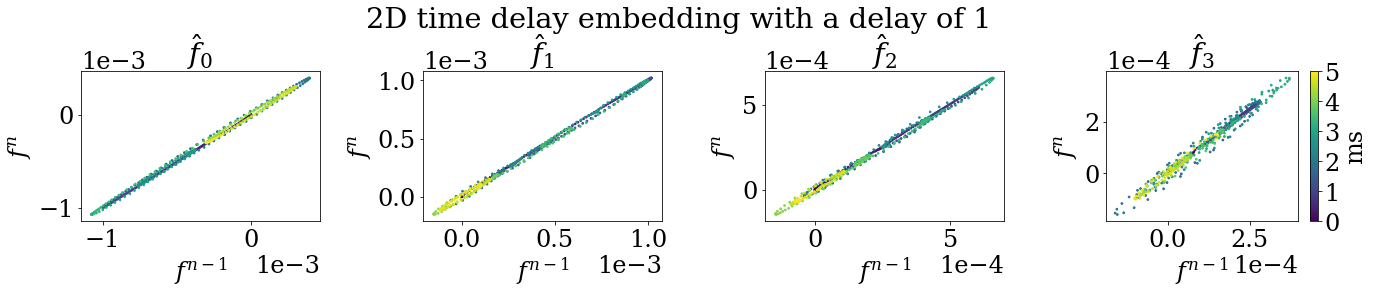

In [151]:
plt.figure(figsize=(20,5))
for i in range(pod_size):
    plt.subplot(1,pod_size,i+1)
    plt.scatter(naive_fint_r[i,:,0],naive_fint_r[i,:,1],s=3, c=0.01*np.arange(501))
    plt.title(rf"$\hat{{f}}_{i}$")
    plt.ticklabel_format(scilimits=(-1,1))
    plt.xlabel(r"$f^{n-1}$")
    plt.ylabel(r"$f^{n}$")
plt.colorbar(label='ms',ticks=range(6))
plt.suptitle("2D time delay embedding with a delay of 1", y=0.85)
plt.tight_layout()

### "Optimal"

In [13]:
for i in range(pod_size):
    print(gt.takens_embedding_optimal_parameters(mat2.fint_r.T[i], max_time_delay=100, max_dimension=5))

(23, 5)
(13, 3)
(10, 5)
(19, 3)


In [14]:
for i in range(pod_size):
    print(gt.takens_embedding_optimal_parameters(mat2.fint_r.T[i], max_time_delay=50, max_dimension=10))

(23, 9)
(13, 6)
(10, 7)
(19, 9)


In [15]:
for i in range(pod_size):
    print(gt.takens_embedding_optimal_parameters(mat2.fint_r.T[i], max_time_delay=20, max_dimension=25))

(19, 14)
(13, 12)
(10, 7)
(19, 9)


POD 0: time delay = 23, dimension = 9
POD 1: time delay = 13, dimension = 6
POD 2: time delay = 10, dimension = 7
POD 3: time delay = 19, dimension = 9


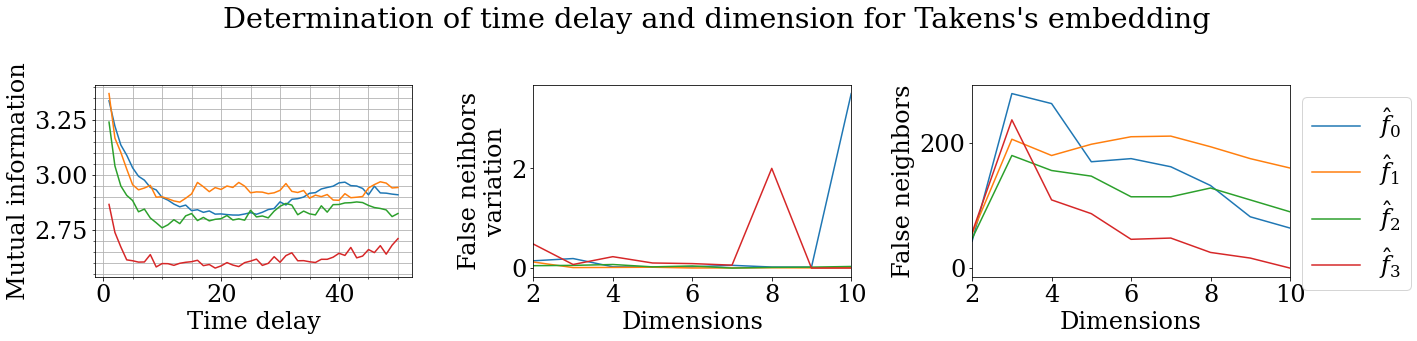

In [31]:
from modifications import takens_embedding_optimal_parameters as takens_embedding_optimal_parameters_modified
plt.figure(figsize=(20,5))
for i in range(pod_size):
    time_delay, dimension, mutual_information_list, variation_list, n_false_nbhrs_list = takens_embedding_optimal_parameters_modified(mat2.fint_r.T[i], max_time_delay=50, max_dimension=10)
    plt.subplot(131)
    plt.plot(np.arange(1,len(mutual_information_list)+1),mutual_information_list,label=f"POD {i}")
    plt.ylabel('Mutual information')
    plt.xlabel("Time delay")
    if i == pod_size - 1:
        plt.minorticks_on()
        plt.grid(which='both')
    plt.subplot(132)
    plt.plot(np.arange(2,len(variation_list)+2),variation_list,label=f"POD {i}")
    plt.ylabel("False neihbors\nvariation")
    plt.xlabel("Dimensions")
    plt.xlim([2, 10])
    plt.grid()
    plt.subplot(133)
    plt.plot(np.arange(2,len(n_false_nbhrs_list[:-3])+2),n_false_nbhrs_list[:-3],label=rf"$\hat{{f}}_{i}$")
    plt.ylabel('False neighbors')
    plt.xlabel('Dimensions')
    plt.xlim([2, 10])
    plt.grid()
    print(f"POD {i}: time delay = {time_delay}, dimension = {dimension}")
    
plt.suptitle("Determination of time delay and dimension for Takens's embedding")
plt.legend(bbox_to_anchor=(1,1), loc = "upper left")
plt.tight_layout()


#### 2D

In [17]:
smart_dimension = 9
smart_time_delay = 23

In [18]:
smartTE_2D = gt.TakensEmbedding(time_delay=smart_time_delay)
smartTE_2D_fint_r = smartTE_2D.fit_transform(takens_pad(mat2.fint_r,smart_time_delay))

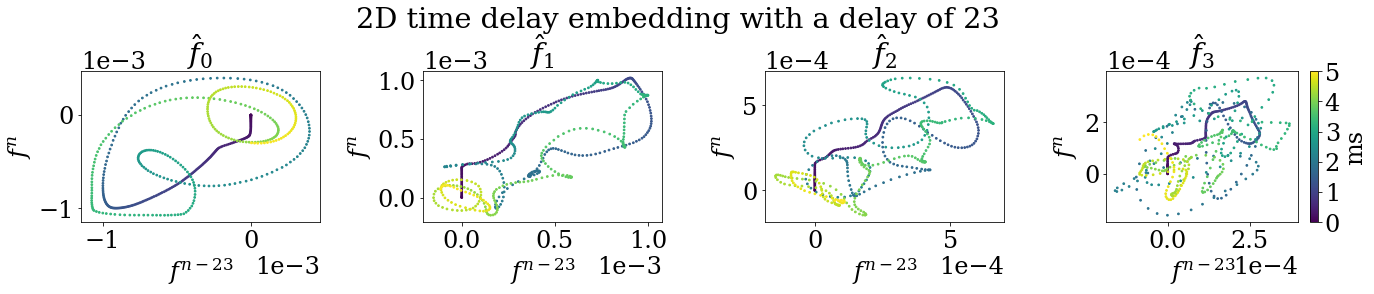

In [19]:
plt.figure(figsize=(20,5))
for i in range(pod_size):
    plt.subplot(1,pod_size,i+1)
    plt.scatter(smartTE_2D_fint_r[i,:,0],smartTE_2D_fint_r[i,:,1],s=3, c=0.01*np.arange(501))
    plt.title(rf"$\hat{{f}}_{i}$")
    plt.ticklabel_format(scilimits=(-1,1))
    plt.xlabel(rf"$f^{{n-{smart_time_delay}}}$")
    plt.ylabel(r"$f^{n}$")
plt.colorbar(label='ms',ticks=range(6))
plt.suptitle(f"2D time delay embedding with a delay of {smart_time_delay}",y=.85)
plt.tight_layout()

In [165]:
smartTE_2D = gt.TakensEmbedding(time_delay=23)
smartTE_2D_fint_r = smartTE_2D.fit_transform(takens_pad(mat2.fint_r,23))

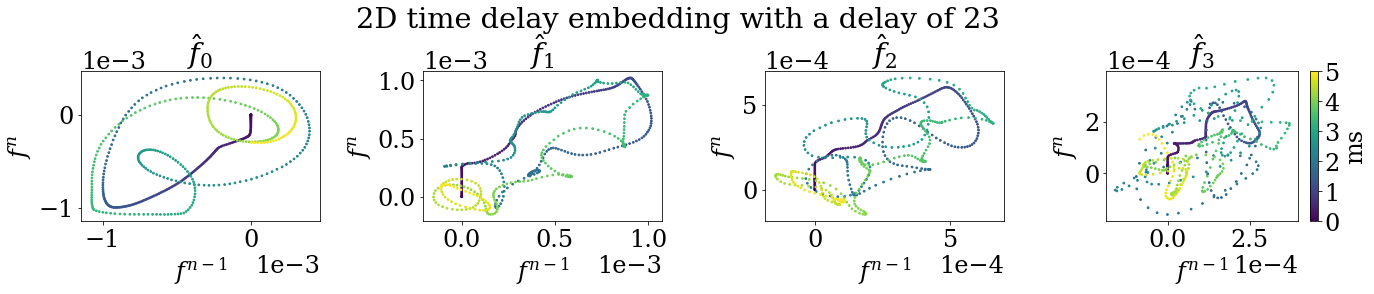

In [166]:
plt.figure(figsize=(20,5))
for i in range(pod_size):
    plt.subplot(1,pod_size,i+1)
    plt.scatter(smartTE_2D_fint_r[i,:,0],smartTE_2D_fint_r[i,:,1],s=3, c=0.01*np.arange(501))
    plt.title(rf"$\hat{{f}}_{i}$")
    plt.ticklabel_format(scilimits=(-1,1))
    plt.xlabel(r"$f^{n-1}$")
    plt.ylabel(r"$f^{n}$")
plt.colorbar(label='ms', ticks=range(6))
plt.suptitle(f"2D time delay embedding with a delay of 23", y=.85)
plt.tight_layout()

#### All dimensions

In [ ]:
smartTE = gt.TakensEmbedding(time_delay=smart_time_delay,dimension=smart_dimension)

smartTE_fint_r = smartTE.fit_transform(takens_pad(mat2.fint_r,smart_time_delay,smart_dimension))

C:\Users\etodorov\AppData\Local\Temp\ipykernel_8028\263952140.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


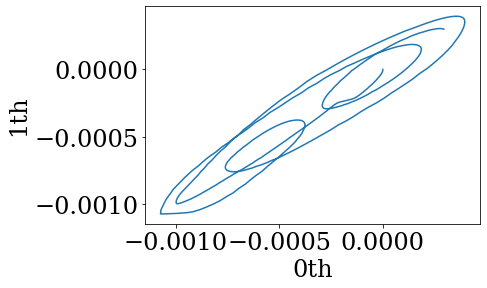

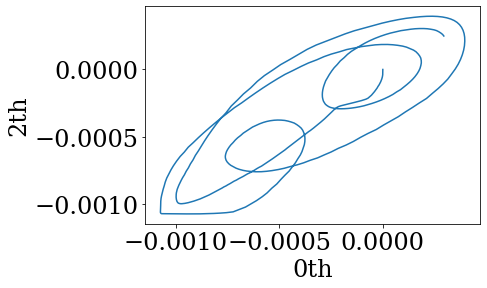

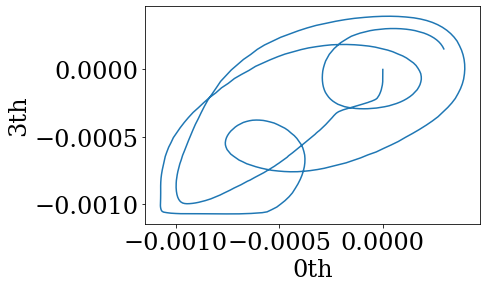

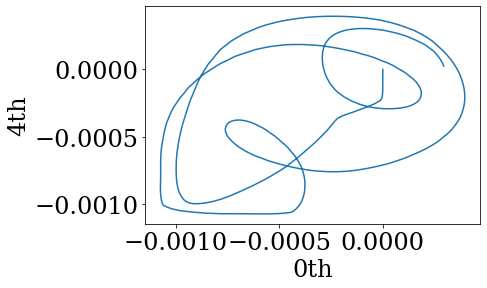

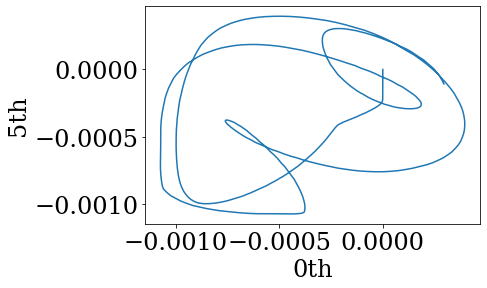

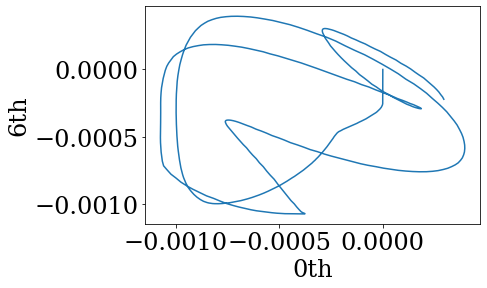

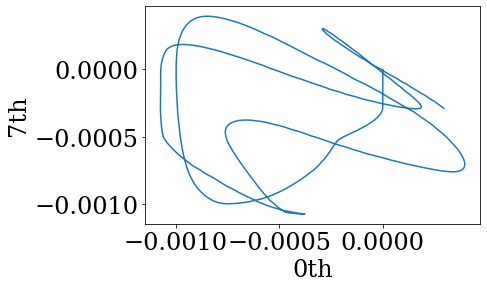

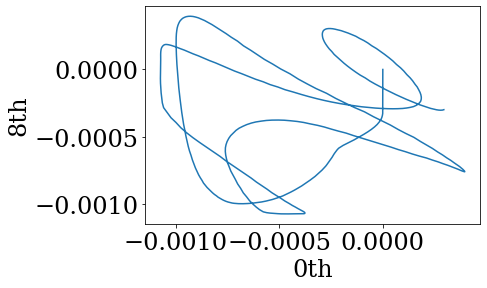

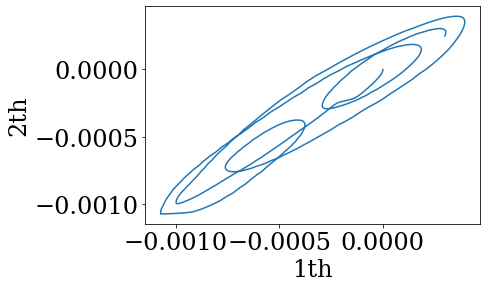

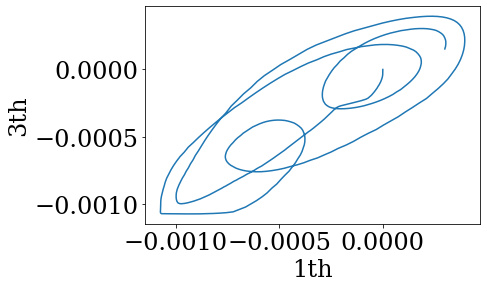

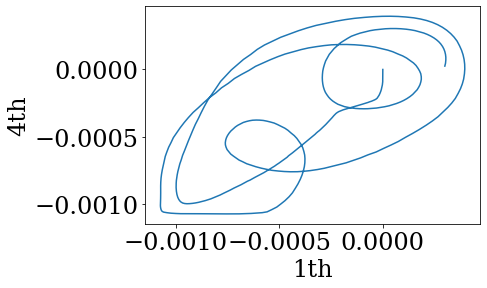

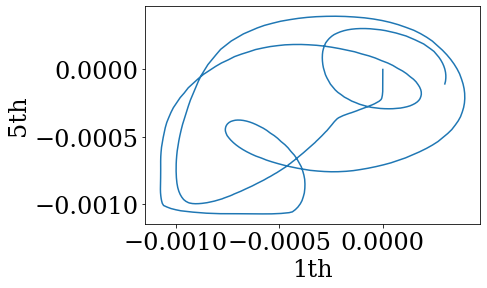

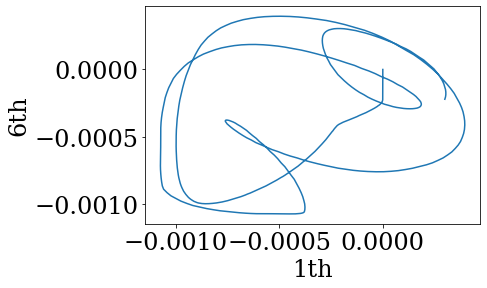

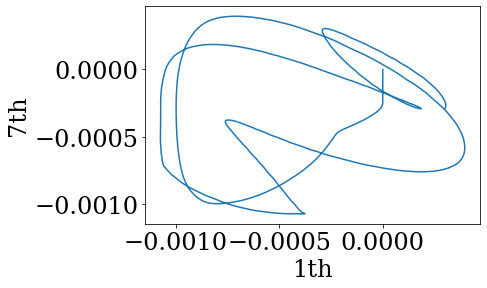

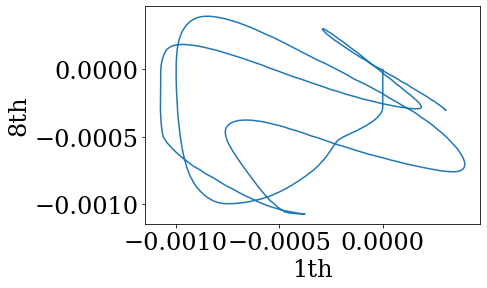

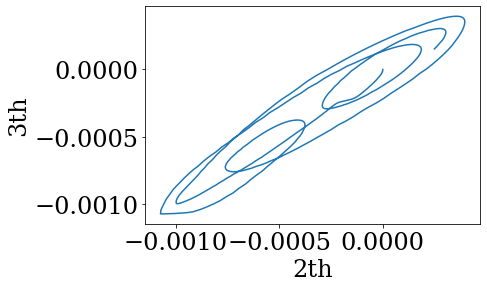

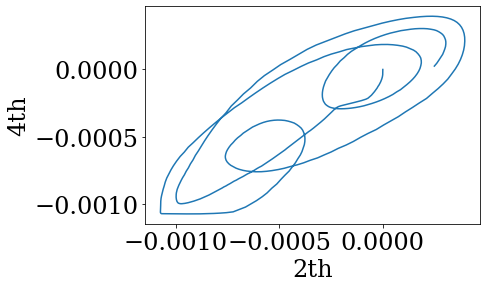

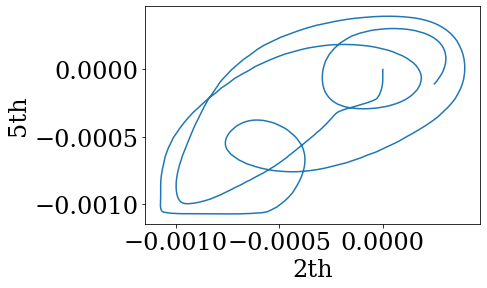

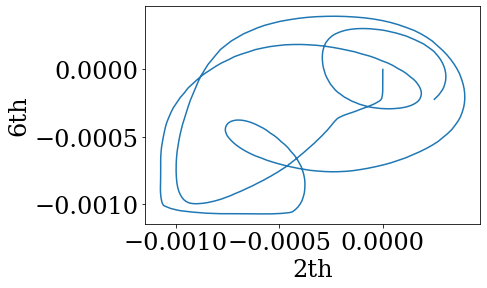

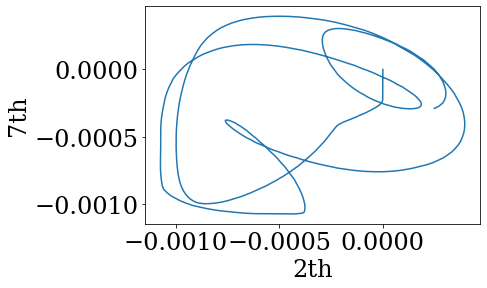

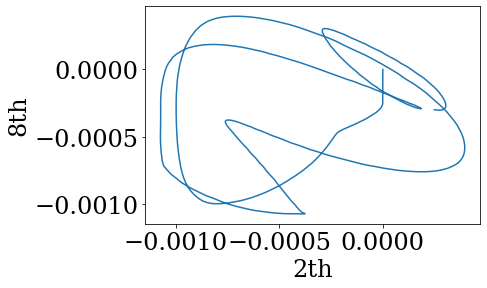

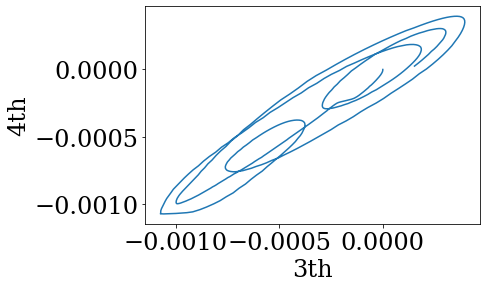

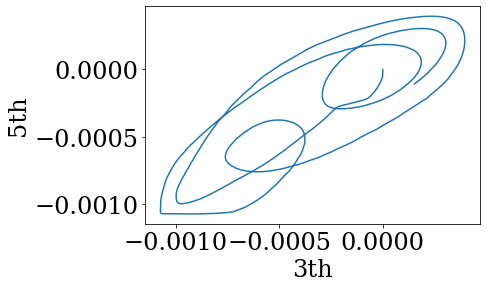

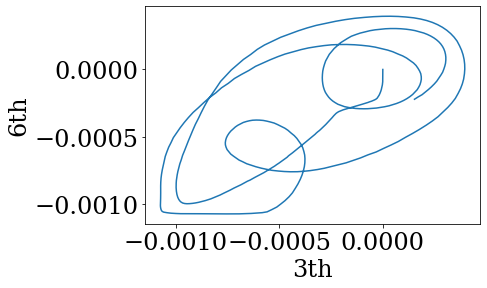

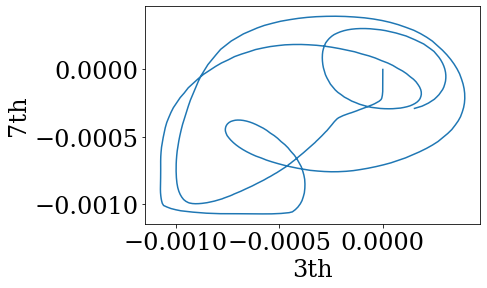

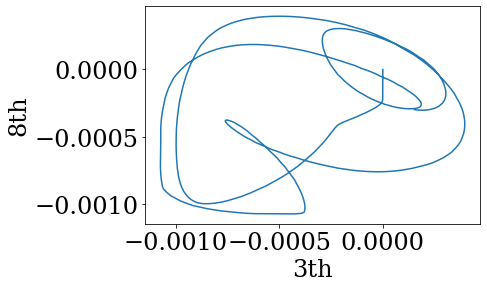

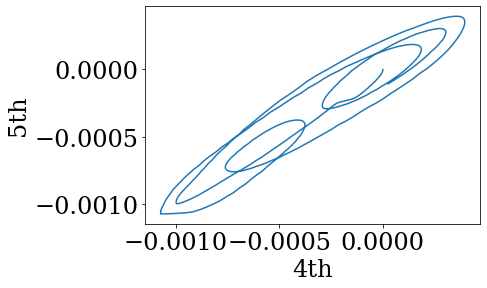

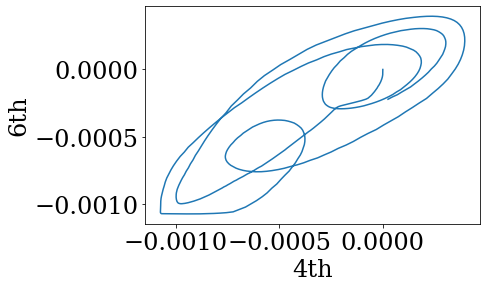

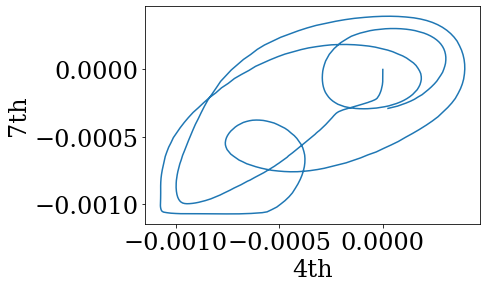

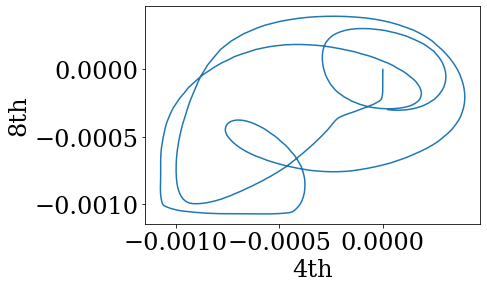

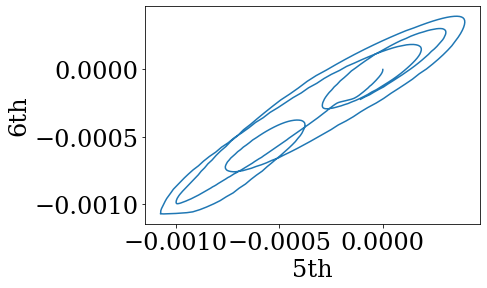

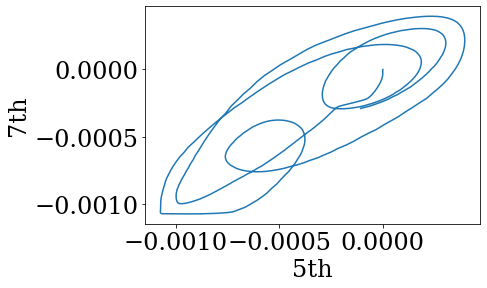

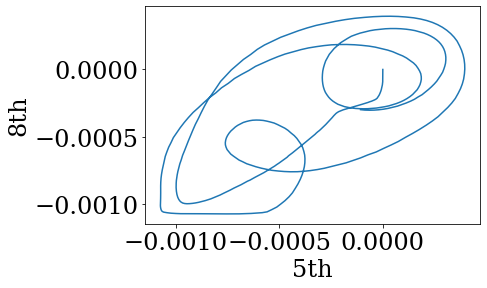

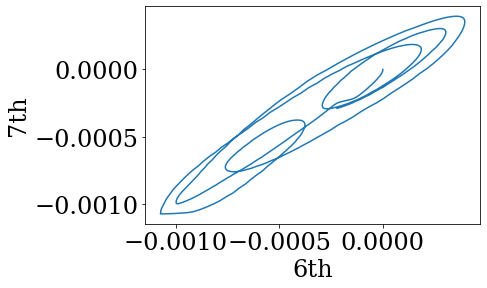

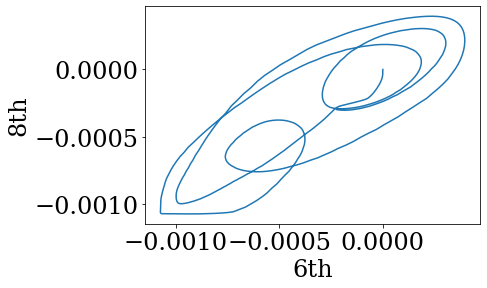

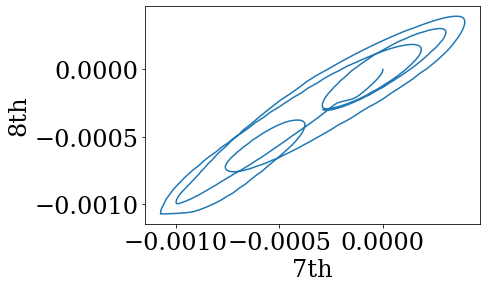

In [38]:
from itertools import combinations
combs = list(combinations(range(dimension),2))
for i, j in combs:
    plt.figure()
    plt.plot(smartTE_fint_r[0,:,i],smartTE_fint_r[0,:,j])
    plt.xlabel(f'{i}th')
    plt.ylabel(f'{j}th')

## Force-history augmented Models

### Helper functions

In [20]:
def dr_fint_takens_trainfunc_base(mat, stop=501, delay=1, dimensions = 2):
    TE = gt.TakensEmbedding(time_delay=delay, dimension=dimensions)
    _, components = mat.fint_r.shape
    fint_te = TE.fit_transform(takens_pad(mat.fint_r[:stop],delay,dimensions)).transpose(2,0,1).reshape(-1,stop).T
    x_train = np.hstack([
                mat.xr[:stop] - mat.xr[0],
                fint_te[:,:-components]
            ])
    y_train = fint_te[:,-components:]
    return x_train, y_train
    

def dr_fint_takens_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist,delay=1, dimensions = 2):
    try:
        if hist.init != True:
            raise RuntimeError("Error initializing history.")
    except AttributeError:
        hist.fint_r = np.zeros(mat.fint_r.shape)
        hist.init = True
    components = mat.fint_r.shape[1]
    augment = np.zeros((dimensions-1,components))
    for j in range(1,dimensions):
        if i > (dimensions-j)*delay:
            augment[j-1,:] = hist.fint_r[i-(dimensions-j)*delay]
        else:
            augment[j-1,:] = np.zeros(components)
    augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], augment.reshape(1,-1)])
    try:
        fint_r_pred = model.predict(augmented_state.reshape(1,-1))
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    hist.fint_r[i] = fint_r_pred
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

In [21]:
dr_fint_delay1_dim2_trainfunc = NamedFunc(dr_fint_takens_trainfunc_base,'Reduced displacement + last reduced internal force')
dr_fint_delay1_dim2_ar_predfunc = NamedFunc(
            dr_fint_takens_ar_predfunc_base,
            'Prediction from reduced displacement + last reduced internal force'
            )
dr_fint_delay6_dim2_trainfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_trainfunc_base(*args,**kwargs, delay=6),
            'Reduced displacement + reduced internal force delay 6'
)
dr_fint_delay6_dim2_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_ar_predfunc_base(*args,**kwargs,delay=6),
            'Prediction from reduced displacement + reduced internal force delay 6'
            )

dr_fint_delay6_dim4_trainfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_trainfunc_base(*args,**kwargs, delay=6,dimensions=4),
            'Reduced displacement + 3 offsets of reduced internal force with delay 6'
)
dr_fint_delay6_dim4_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_ar_predfunc_base(*args,**kwargs,delay=6,dimensions=4),
            'Prediction from reduced displacement + 3 offsets of reduced internal force with delay 6'
            )

dr_fint_delay23_dim2_trainfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_trainfunc_base(*args,**kwargs, delay=23,dimensions=2),
            'Reduced displacement +  reduced internal force with delay 23'
)
dr_fint_delay23_dim2_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_ar_predfunc_base(*args,**kwargs,delay=23,dimensions=2),
            'Prediction from reduced displacement + reduced internal force with delay 23'
            )

dr_fint_delay6_dim9_trainfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_trainfunc_base(*args,**kwargs, delay=6,dimensions=9),
            'Reduced displacement + 8 offsets of reduced internal force with delay 6'
)
dr_fint_delay6_dim9_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_ar_predfunc_base(*args,**kwargs,delay=6,dimensions=9),
            'Prediction from reduced displacement + 8 offsets of reduced internal force with delay 6'
            )

dr_fint_delay23_dim4_trainfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_trainfunc_base(*args,**kwargs, delay=23,dimensions=4),
            'Reduced displacement + 3 offsets of reduced internal force with delay 23'
)
dr_fint_delay23_dim4_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_ar_predfunc_base(*args,**kwargs,delay=23,dimensions=4),
            'Prediction from reduced displacement + 3 offsets of reduced internal force with delay 23'
            )


dr_fint_delay23_dim9_trainfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_trainfunc_base(*args,**kwargs, delay=23,dimensions=9),
            'Reduced displacement + 8 offsets of reduced internal force with delay 23'
)
dr_fint_delay23_dim9_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: dr_fint_takens_ar_predfunc_base(*args,**kwargs,delay=23,dimensions=9),
            'Prediction from reduced displacement + 8 offsets of reduced internal force with delay 23'
            )

In [22]:
def drlift_fint_takens_trainfunc_base(mat, stop=501, delay=1, dimensions = 2):
    TE = gt.TakensEmbedding(time_delay=delay, dimension=dimensions)
    _, components = mat.fint_r.shape
    xrlift =  MonomialFeatures(3).fit_transform(mat.xr[:stop] - mat.xr[0]) 
    fint_te = TE.fit_transform(takens_pad(mat.fint_r[:stop],delay,dimensions)).transpose(2,0,1).reshape(-1,stop).T
    x_train = np.hstack([
                xrlift,
                fint_te[:,:-components]
            ])
    y_train = fint_te[:,-components:]
    return x_train, y_train

def drlift_fint_takens_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist,delay=1, dimensions = 2):
    try:
        if hist.init != True:
            raise RuntimeError("Error initializing history.")
    except AttributeError:
        hist.fint_r = np.zeros(mat.fint_r.shape)
        hist.init = True
    components = mat.fint_r.shape[1]
    augment = np.zeros((dimensions-1,components))
    for j in range(1,dimensions):
        if i > (dimensions-j)*delay:
            augment[j-1,:] = hist.fint_r[i-(dimensions-j)*delay]
        else:
            augment[j-1,:] = np.zeros(components)
    
    try:
        xrlift = MonomialFeatures(3).fit_transform((x.reshape(1,-1)-mat.xr[0]))
        augmented_state = np.hstack([xrlift.reshape(1,-1), augment.reshape(1,-1)])
        fint_r_pred = model.predict(augmented_state.reshape(1,-1))
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    hist.fint_r[i] = fint_r_pred
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

In [23]:
drlift_fint_delay6_dim4_trainfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_trainfunc_base(*args,**kwargs, delay=6,dimensions=4),
            'Reduced displacement lifted with 3rd order monomial expansion + 3 offsets of reduced internal force with delay 6'
)
drlift_fint_delay6_dim4_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_ar_predfunc_base(*args,**kwargs,delay=6,dimensions=4),
            'Prediction from reduced displacement lifted with 3rd order monomial expansion + 3 offsets of reduced internal force with delay 6'
            )
drlift_fint_delay6_dim9_trainfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_trainfunc_base(*args,**kwargs, delay=6,dimensions=9),
            'Reduced displacement lifted with 3rd order monomial expansion + 8 offsets of reduced internal force with delay 6'
)
drlift_fint_delay6_dim9_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_ar_predfunc_base(*args,**kwargs,delay=6,dimensions=9),
            'Prediction from reduced displacement lifted with 3rd order monomial expansion + 8 offsets of reduced internal force with delay 6'
            )

drlift_fint_delay23_dim4_trainfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_trainfunc_base(*args,**kwargs, delay=23,dimensions=4),
            'Reduced displacement lifted with 3rd order monomial expansion + 3 offsets of reduced internal force with delay 23'
)
drlift_fint_delay23_dim4_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_ar_predfunc_base(*args,**kwargs,delay=23,dimensions=4),
            'Prediction from reduced displacement lifted with 3rd order monomial expansion + 3 offsets of reduced internal force with delay 23'
            )


drlift_fint_delay23_dim9_trainfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_trainfunc_base(*args,**kwargs, delay=23,dimensions=9),
            'Reduced displacement lifted with 3rd order monomial expansion + 8 offsets of reduced internal force with delay 23'
)
drlift_fint_delay23_dim9_ar_predfunc = NamedFunc(
            lambda *args,**kwargs: drlift_fint_takens_ar_predfunc_base(*args,**kwargs,delay=23,dimensions=9),
            'Prediction from reduced displacement lifted with 3rd order monomial expansion + 8 offsets of reduced internal force with delay 23'
            )

### Evaluation

#### Least Squares

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Ridge(alpha=0)(Reduced displacement + last reduced internal force, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + last reduced internal force
	POD components:	4
	Training range:	0:300/501


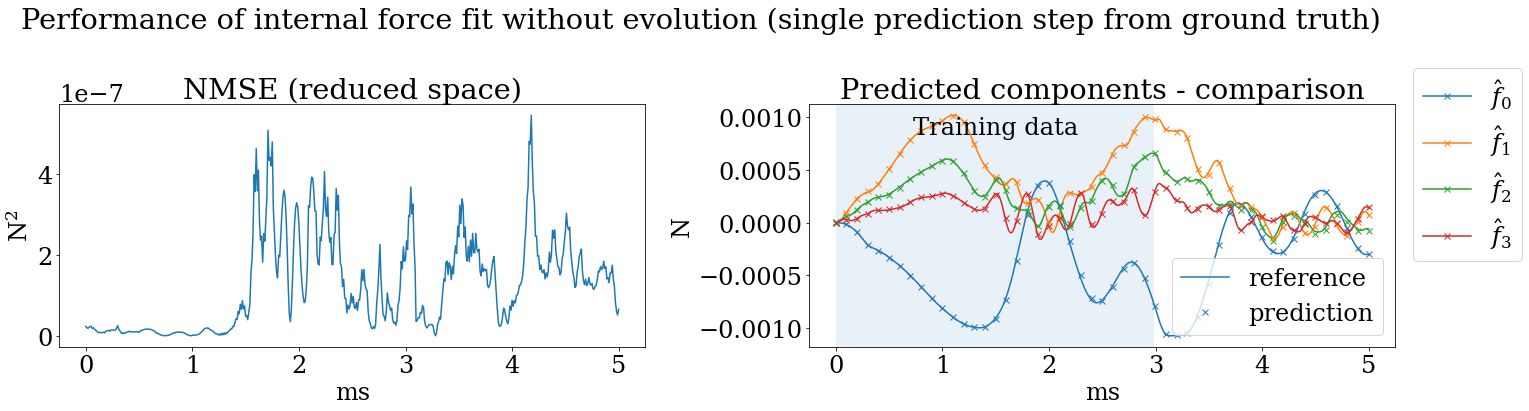

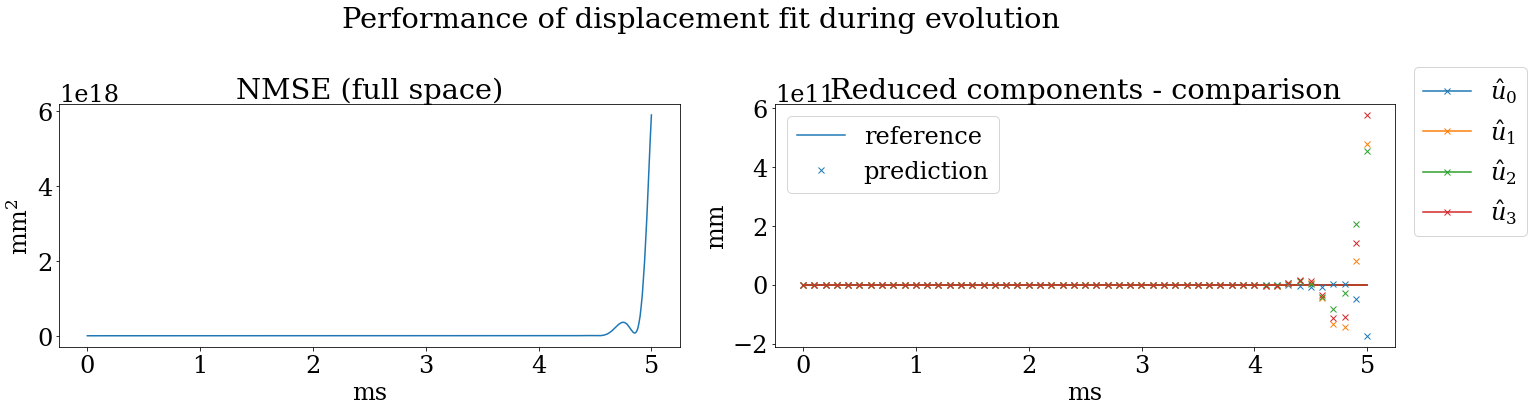

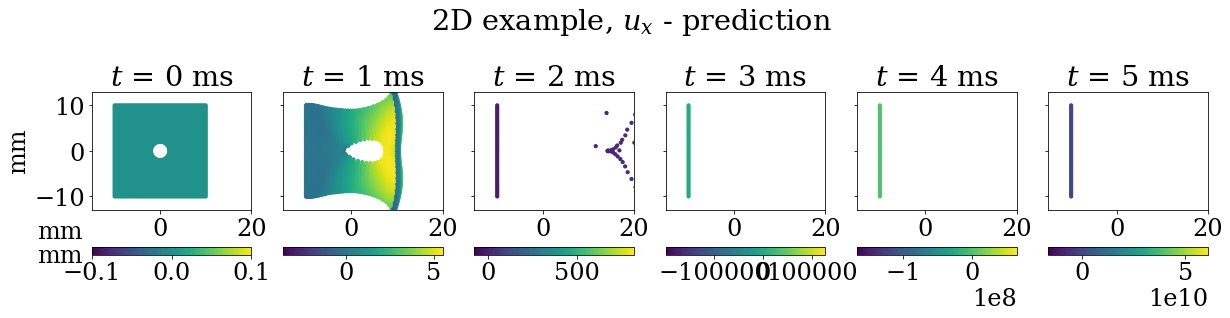

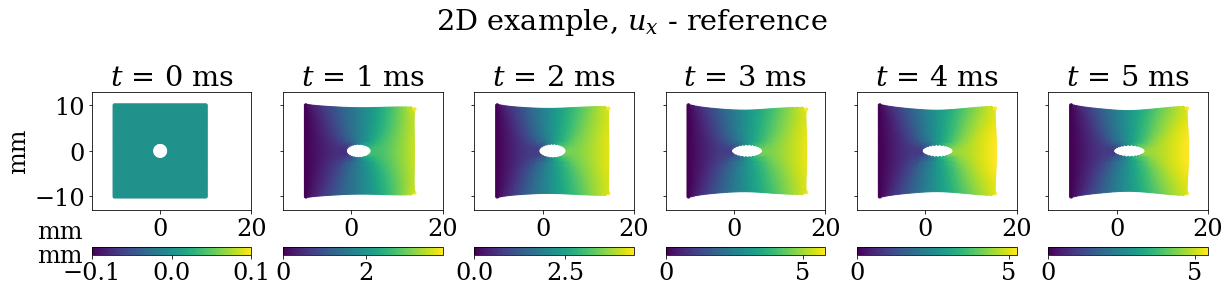

In [137]:
out = evaluate2D(mat2,Ridge(alpha=0),dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_ar_predfunc,4,training_stop=300)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0))])(Reduced displacement + last reduced internal force, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + last reduced internal force
	POD components:	4
	Training range:	0:300/501


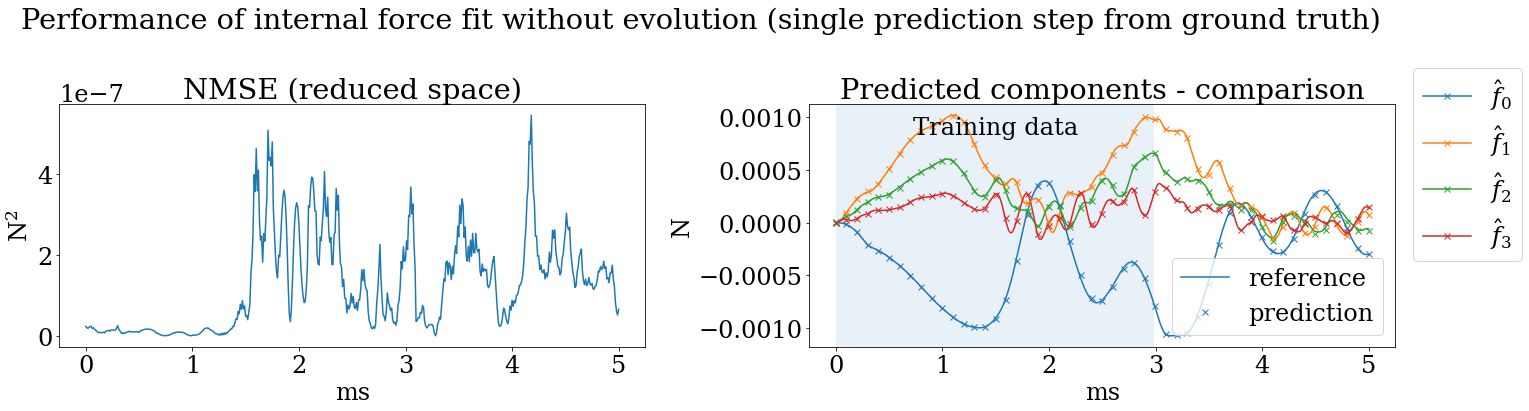

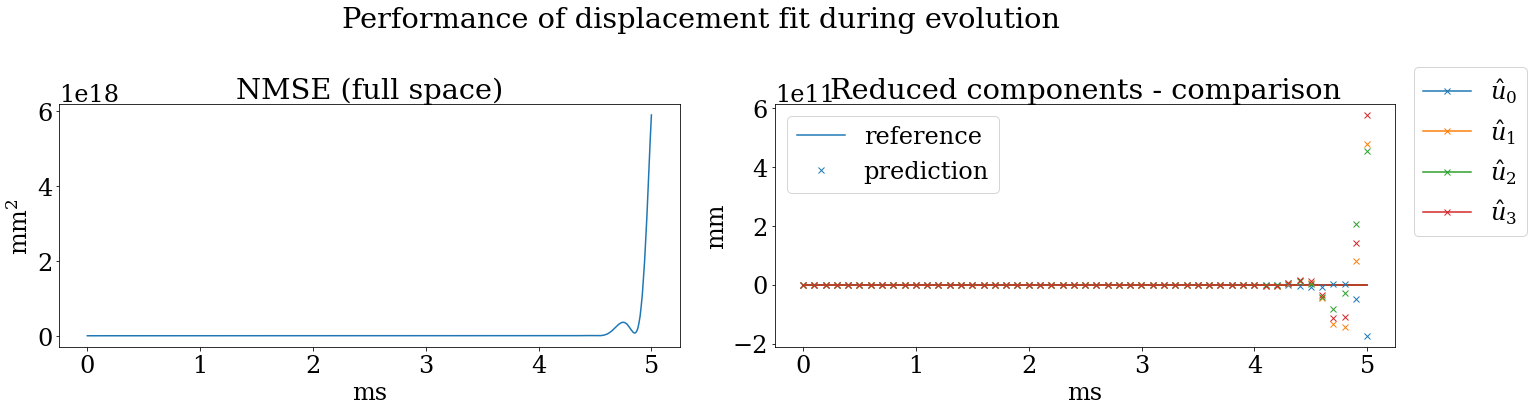

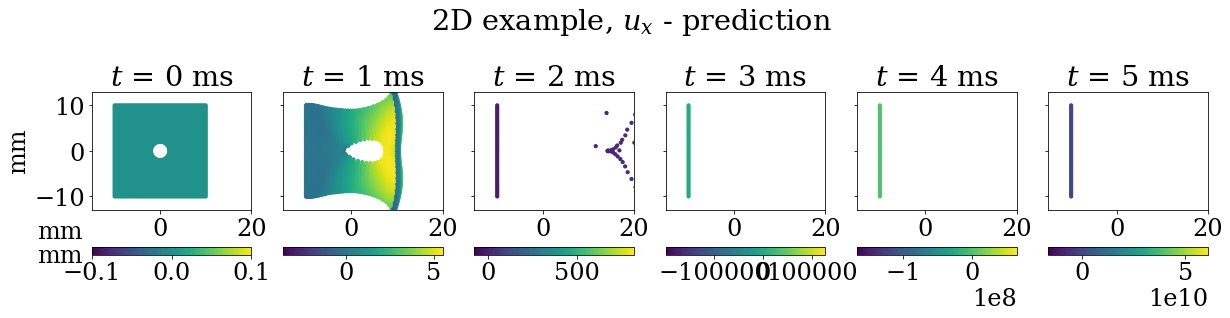

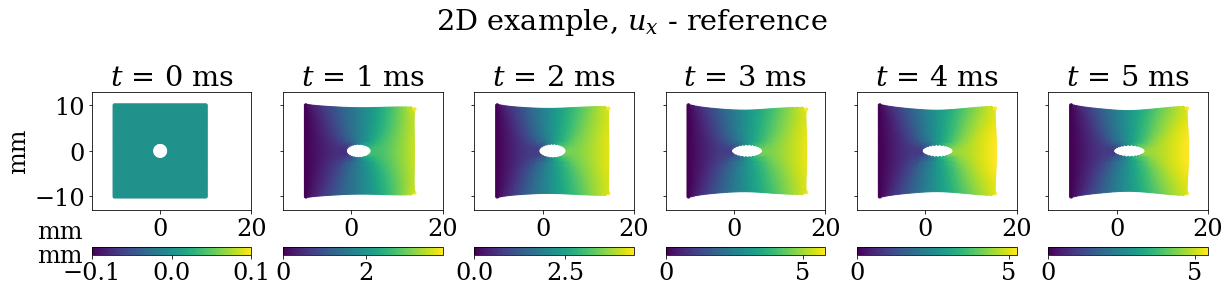

In [185]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=0)),dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_ar_predfunc,4,training_stop=300)

#### Ridge

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Ridge(alpha=1)(Reduced displacement + last reduced internal force, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + last reduced internal force
	POD components:	4
	Training range:	0:300/501


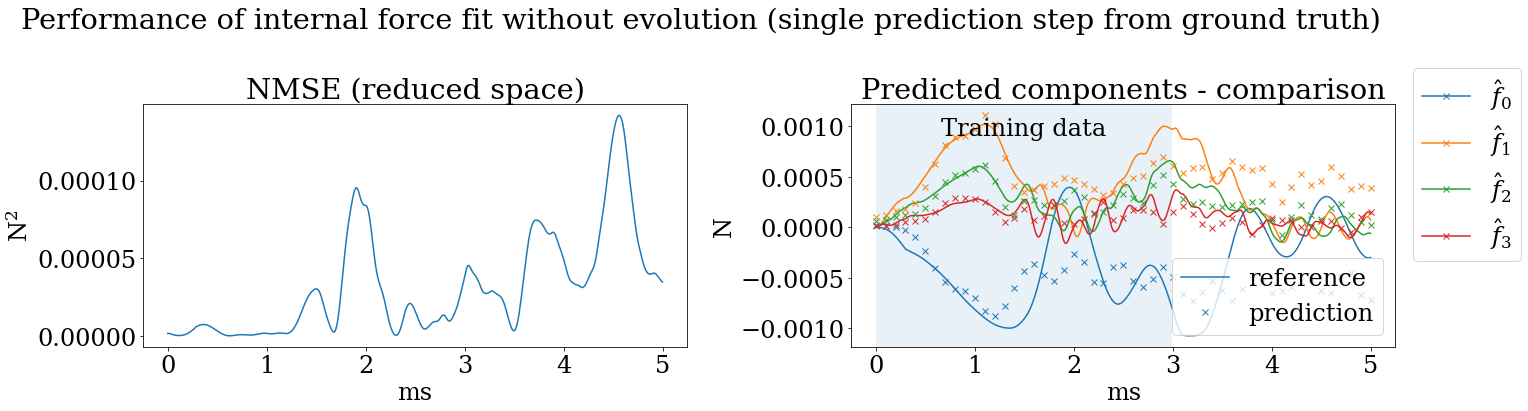

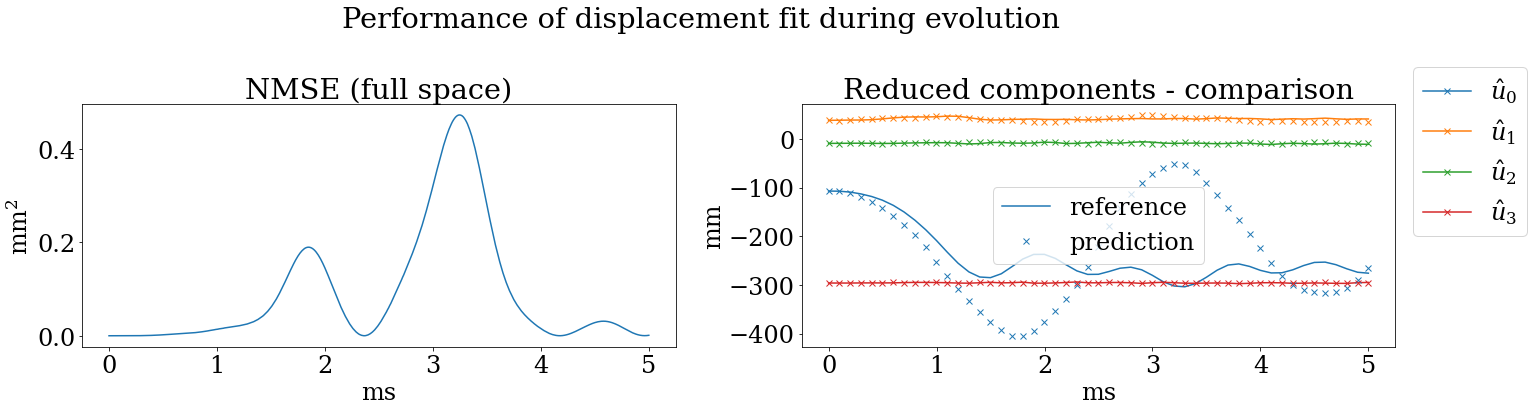

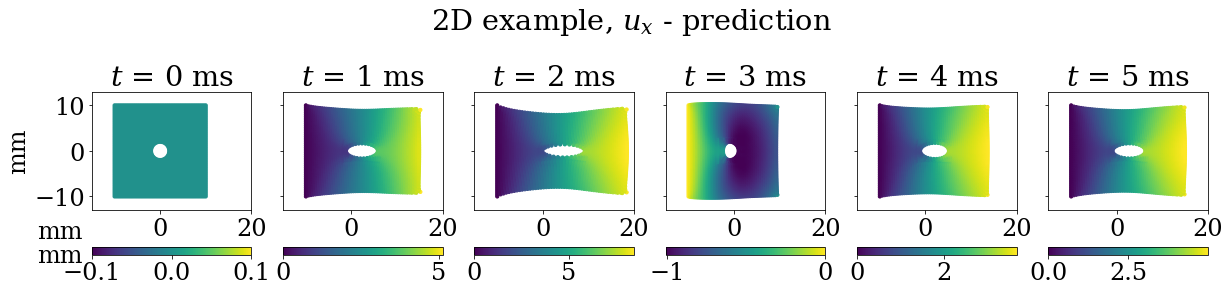

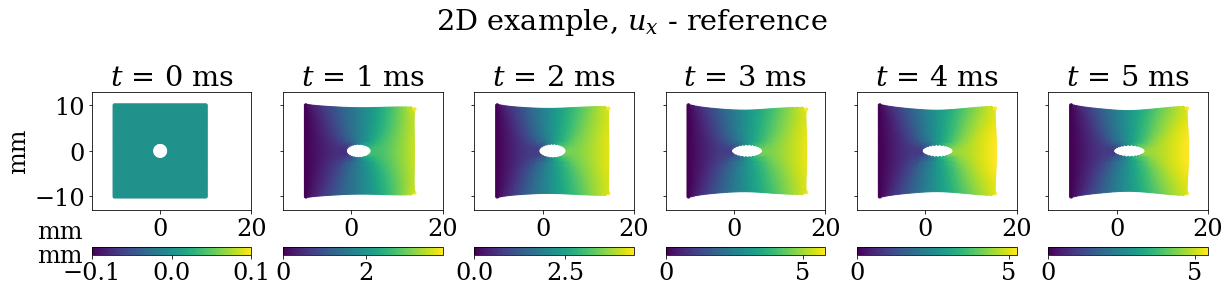

In [187]:
out = evaluate2D(mat2,Ridge(alpha=1),dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_ar_predfunc,4,training_stop=300)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=100))])(Reduced displacement + last reduced internal force, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + last reduced internal force
	POD components:	4
	Training range:	0:300/501


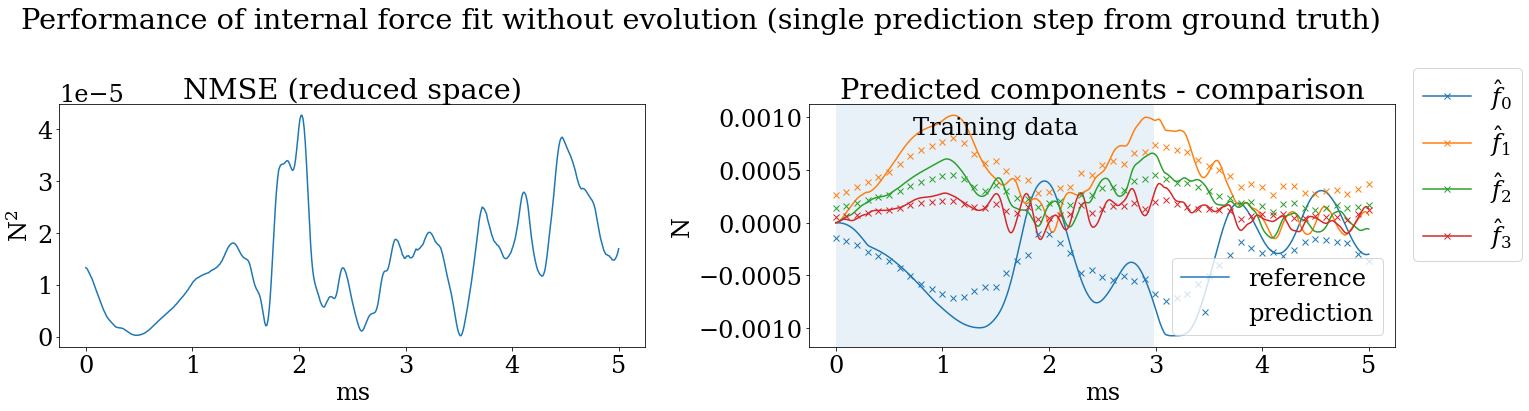

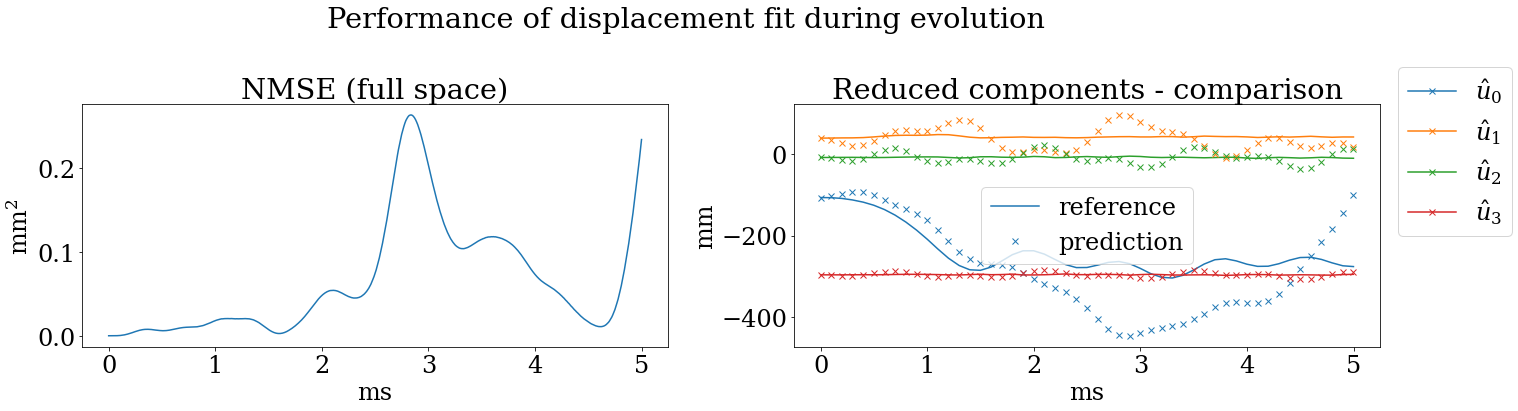

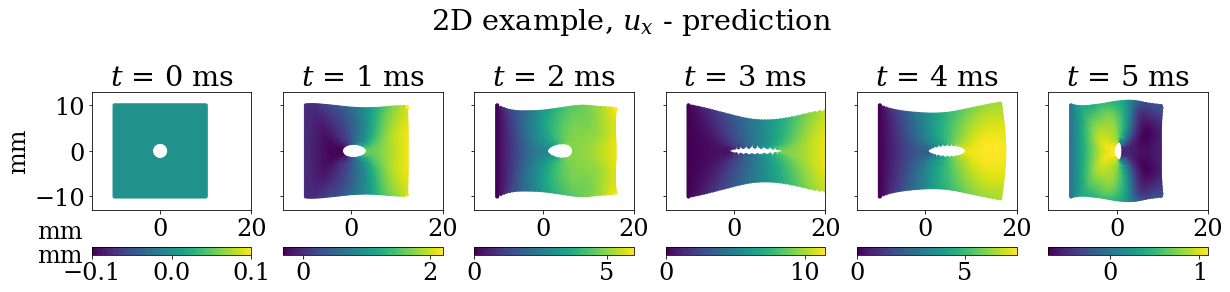

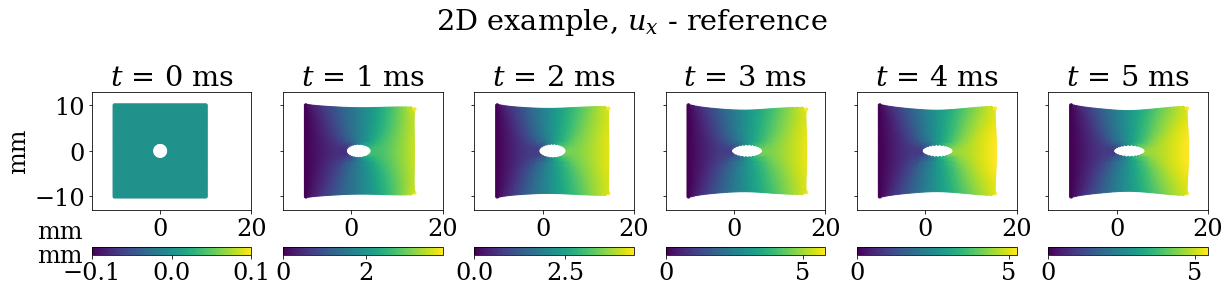

In [192]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=100)),dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_trainfunc, dr_fint_delay1_dim2_ar_predfunc,4,training_stop=300)

#### Fine tuned regularization

##### 2 Dimensions

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=120))])(Reduced displacement + reduced internal force delay 6, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + reduced internal force delay 6
	POD components:	4
	Training range:	0:300/501


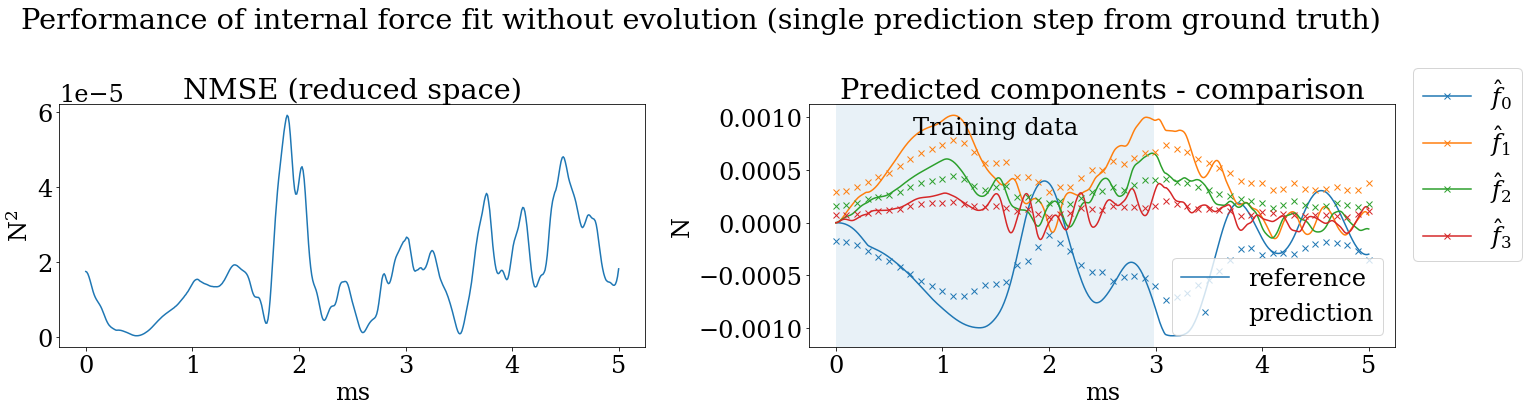

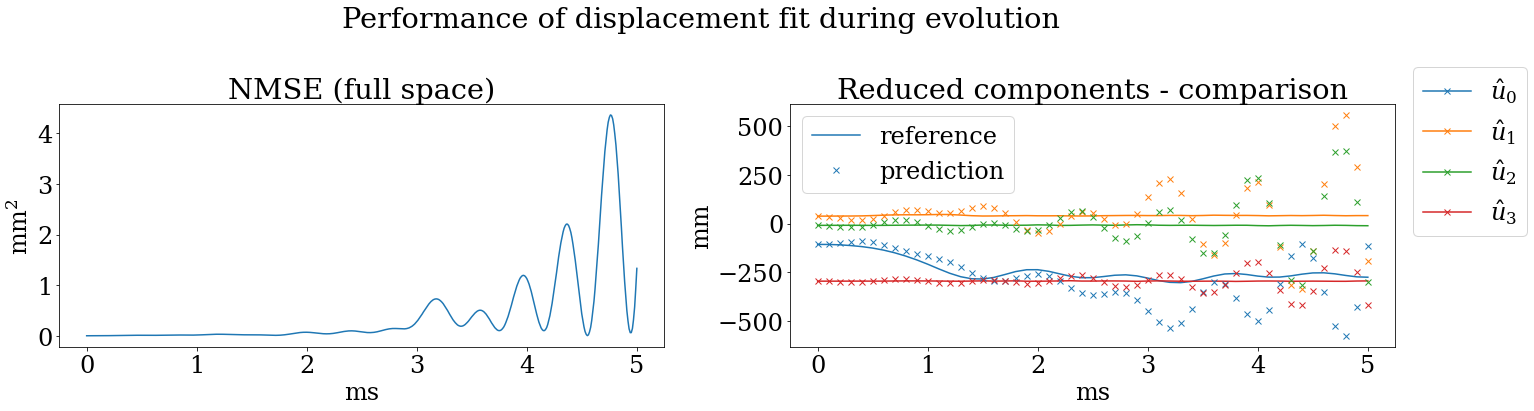

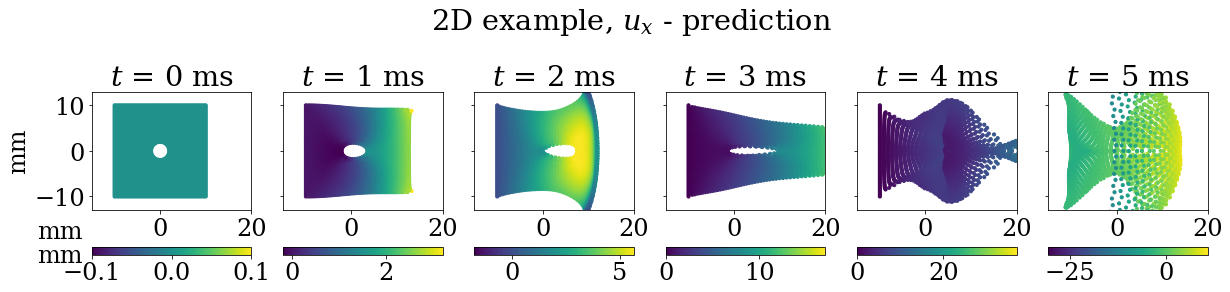

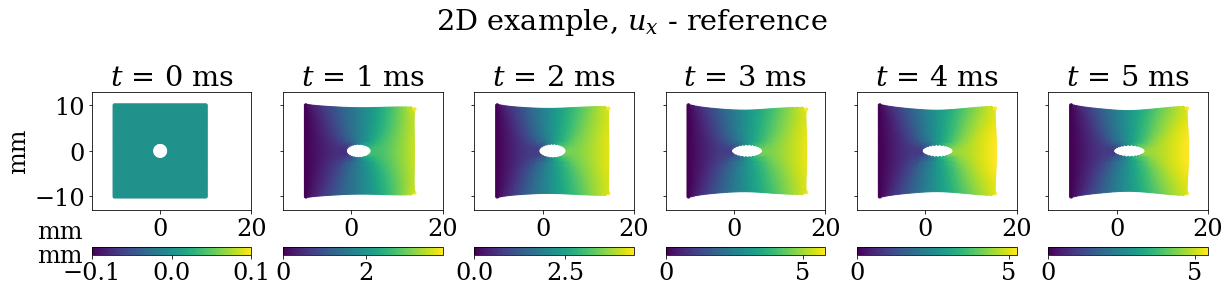

In [199]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=120)),dr_fint_delay6_dim2_trainfunc, dr_fint_delay6_dim2_trainfunc, dr_fint_delay6_dim2_ar_predfunc,4,training_stop=300)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0.2))])(Reduced displacement +  reduced internal force with delay 23, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + reduced internal force with delay 23
	POD components:	4
	Training range:	0:300/501


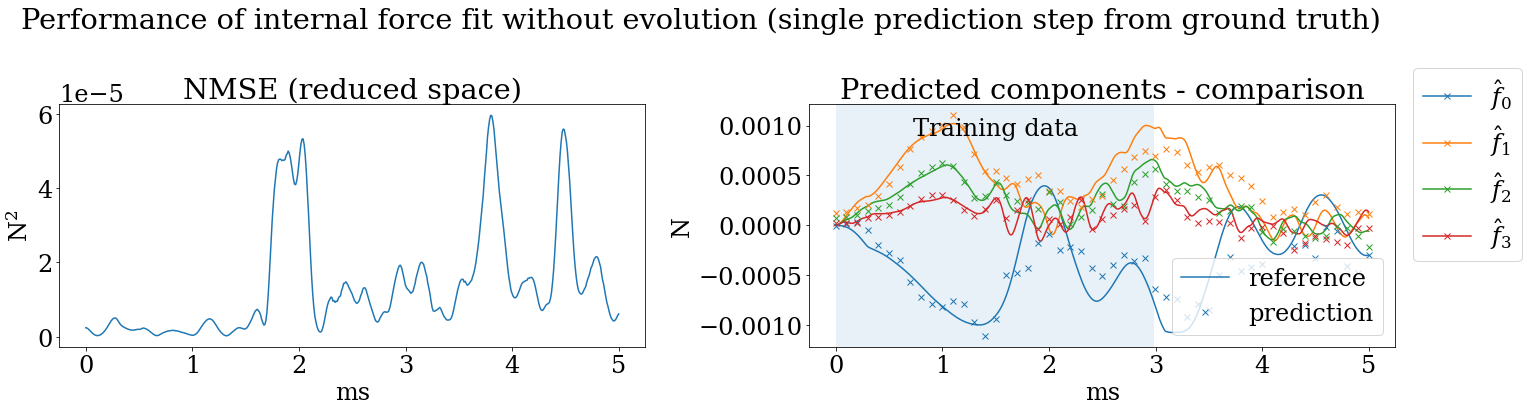

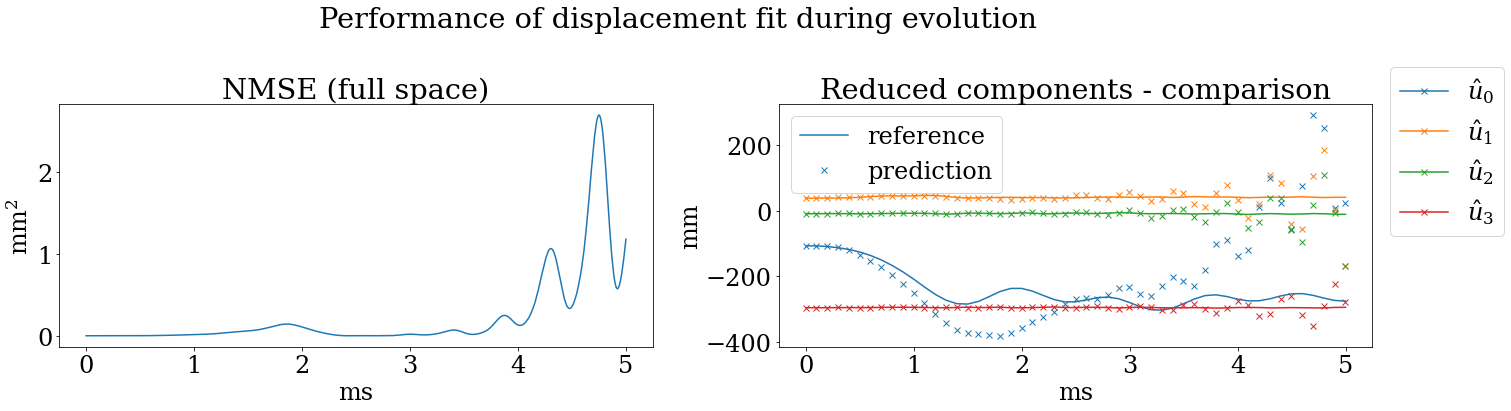

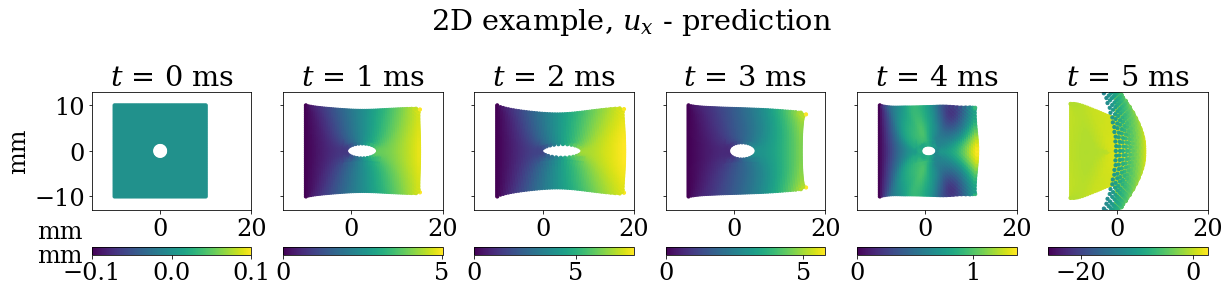

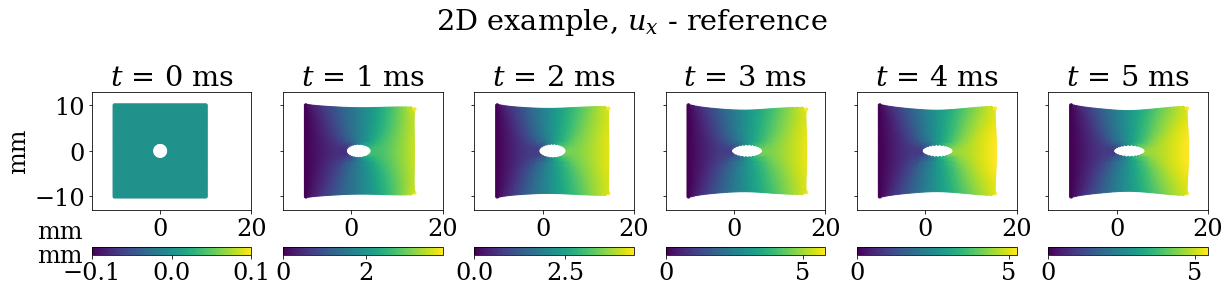

In [203]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=.2)),dr_fint_delay23_dim2_trainfunc, dr_fint_delay23_dim2_trainfunc, dr_fint_delay23_dim2_ar_predfunc,4,training_stop=300)

##### 4 Dimensions

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0.1))])(Reduced displacement + 3 offsets of reduced internal force with delay 6, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + 3 offsets of reduced internal force with delay 6
	POD components:	4
	Training range:	0:300/501


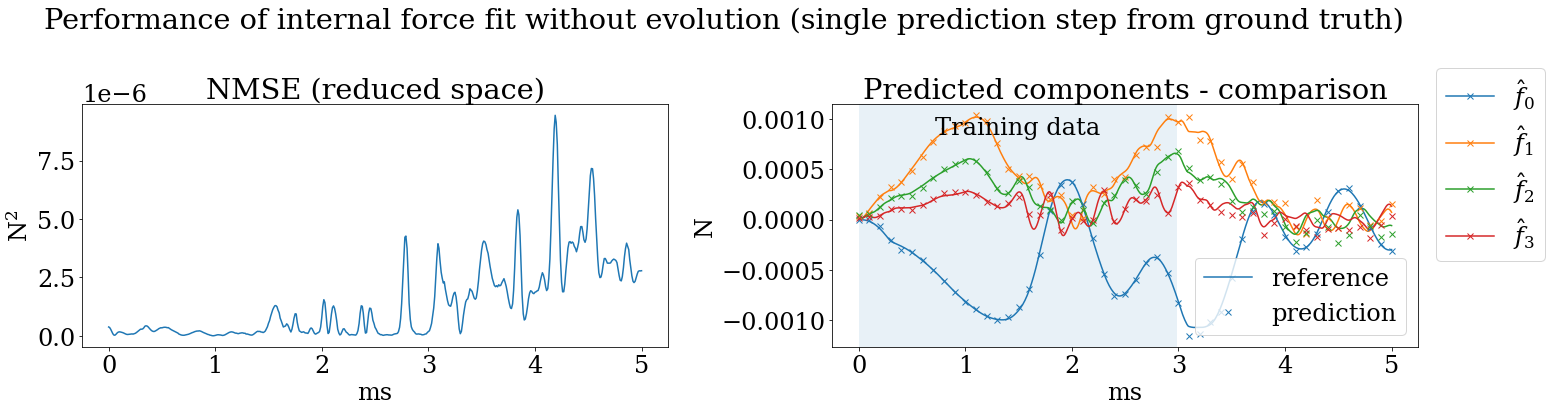

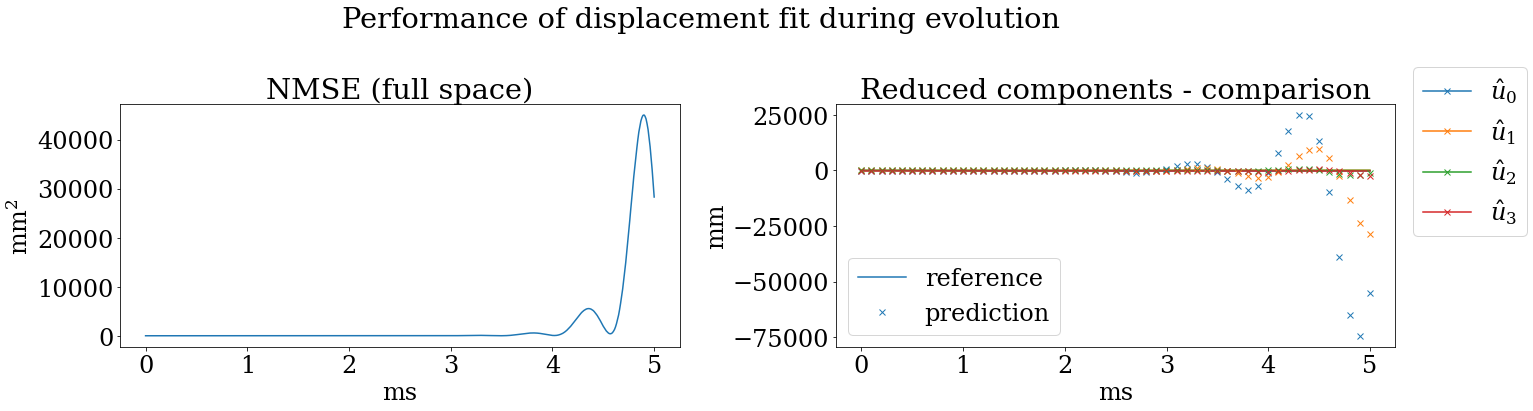

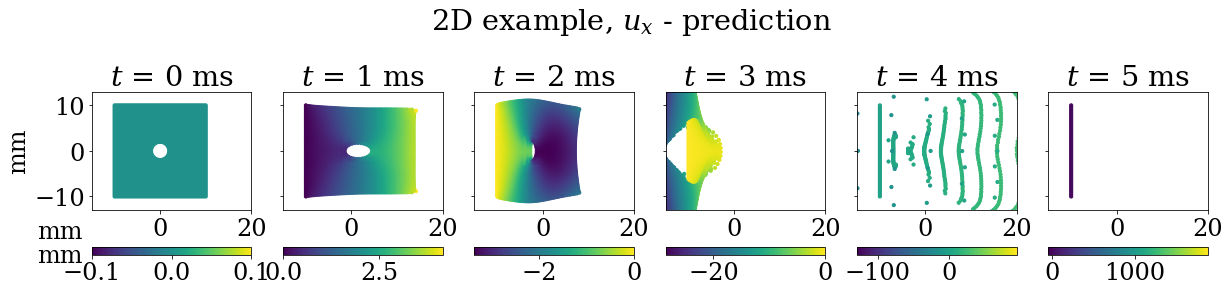

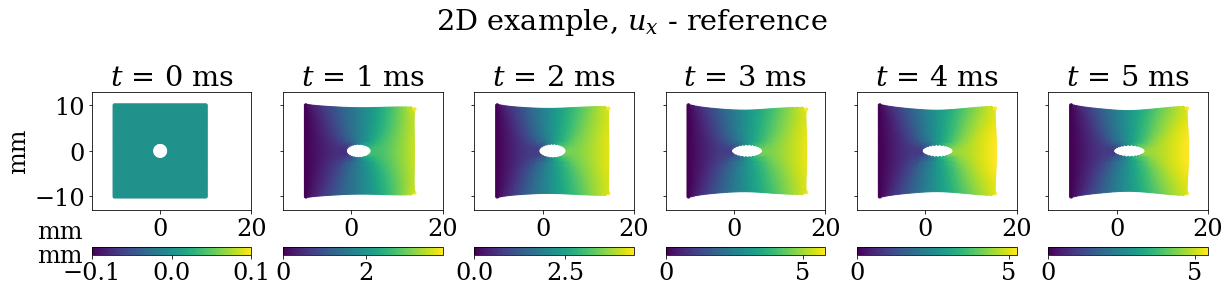

In [312]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=0.1)),dr_fint_delay6_dim4_trainfunc, dr_fint_delay6_dim4_trainfunc, dr_fint_delay6_dim4_ar_predfunc,4,training_stop=300)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0.05))])(Reduced displacement + 3 offsets of reduced internal force with delay 23, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + 3 offsets of reduced internal force with delay 23
	POD components:	4
	Training range:	0:300/501


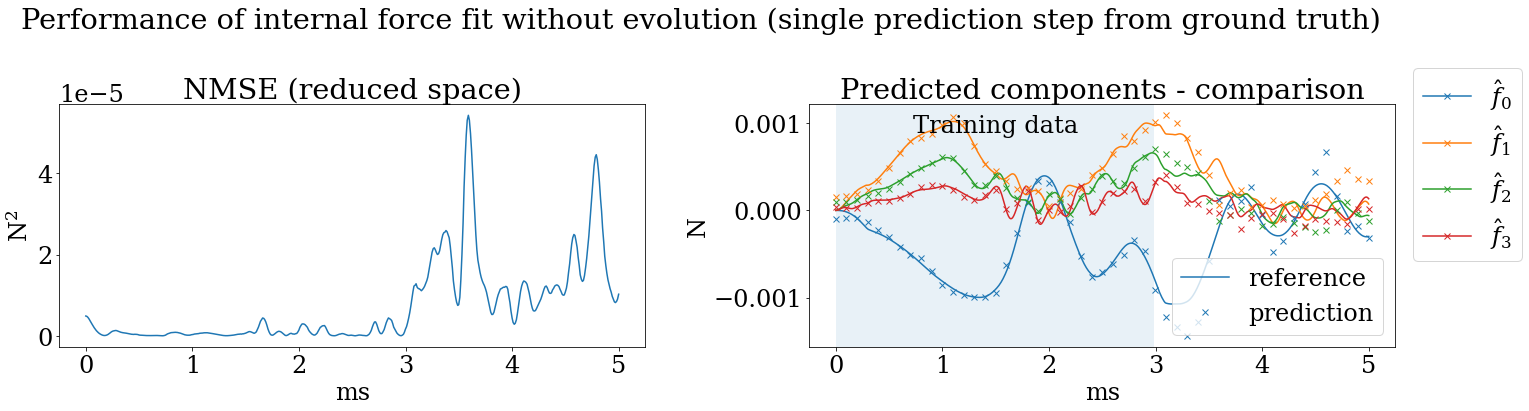

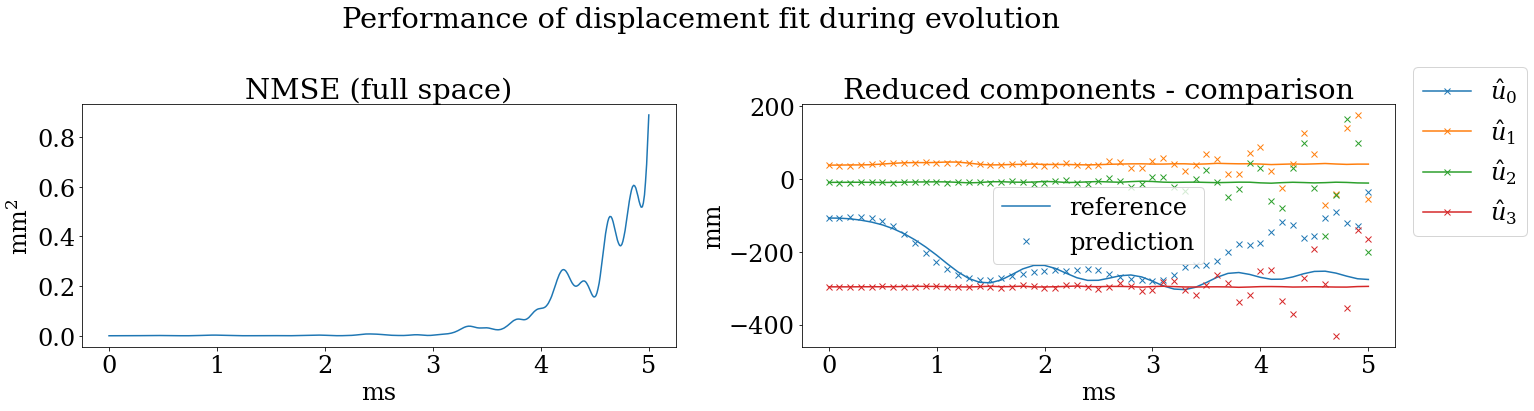

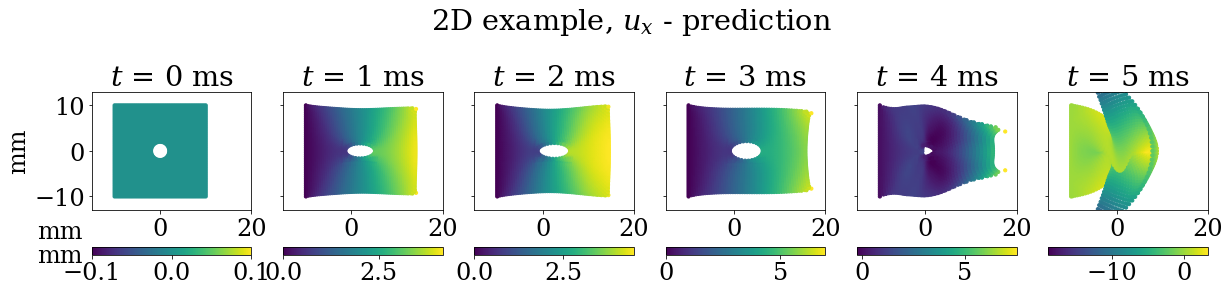

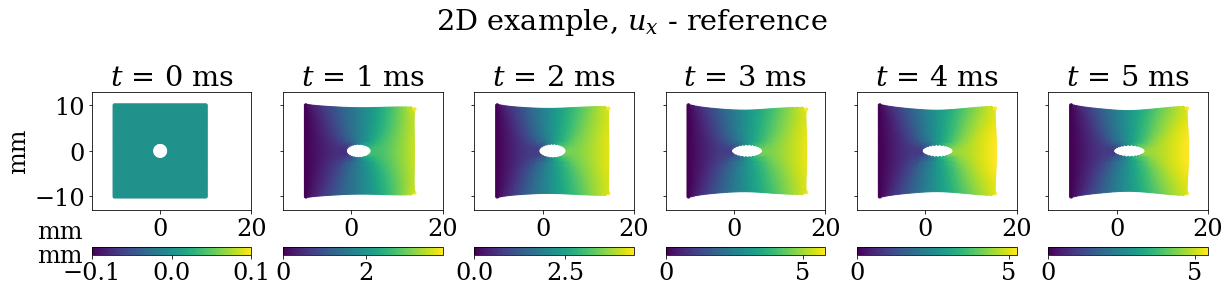

In [314]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=0.05)),dr_fint_delay23_dim4_trainfunc, dr_fint_delay23_dim4_trainfunc, dr_fint_delay23_dim4_ar_predfunc,4,training_stop=300)

##### 9 Dimensions

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=3))])(Reduced displacement + 8 offsets of reduced internal force with delay 6, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + 8 offsets of reduced internal force with delay 6
	POD components:	4
	Training range:	0:300/501


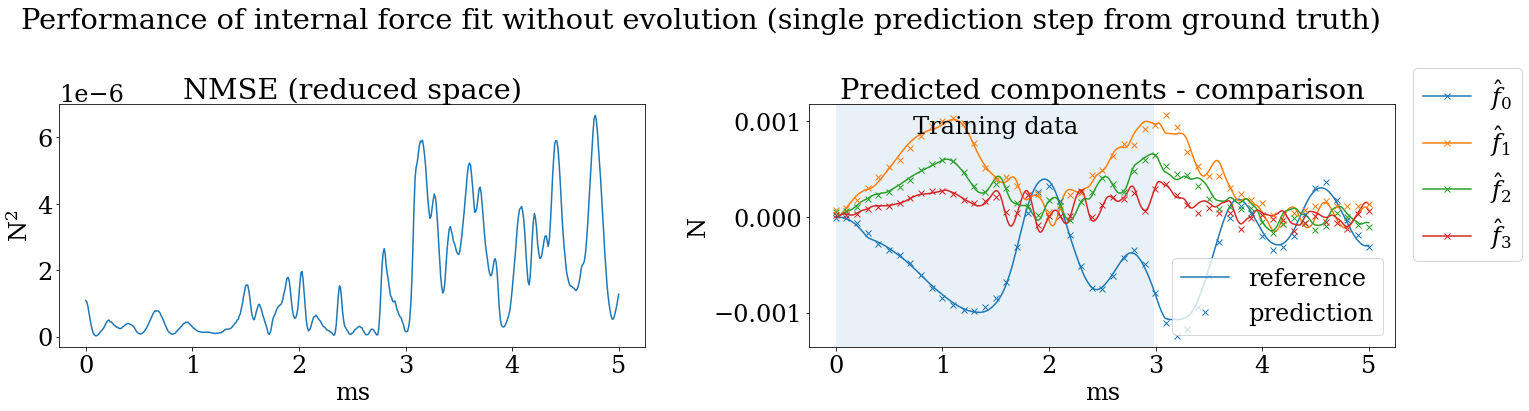

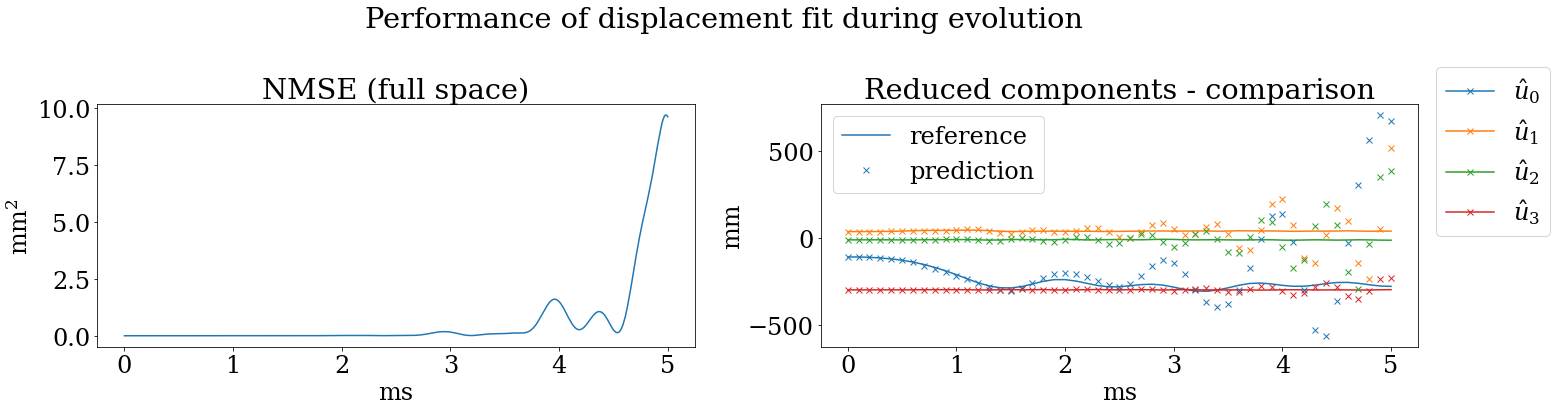

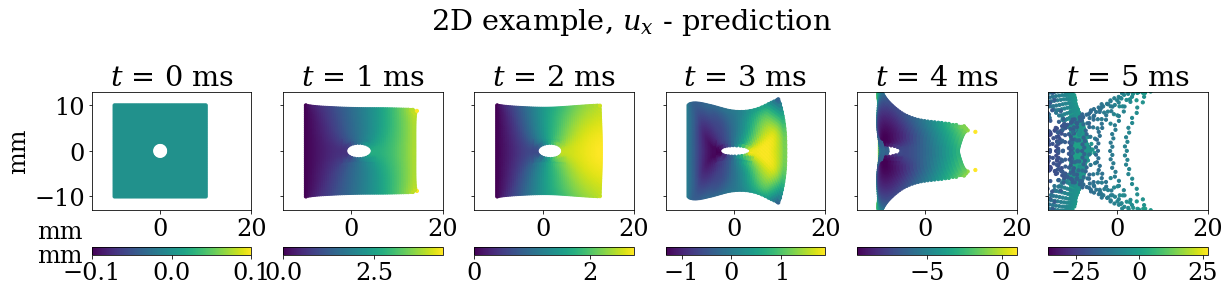

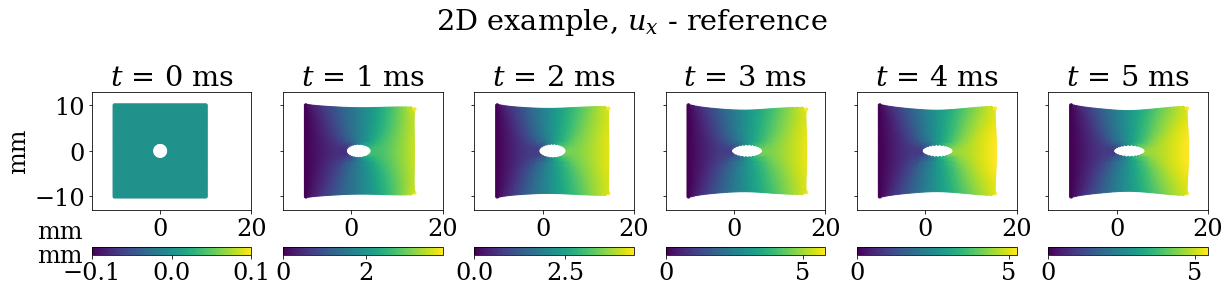

In [309]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=3)),dr_fint_delay6_dim9_trainfunc, dr_fint_delay6_dim9_trainfunc, dr_fint_delay6_dim9_ar_predfunc,4,training_stop=300)

23,9

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=0.05))])(Reduced displacement + 8 offsets of reduced internal force with delay 23, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + 8 offsets of reduced internal force with delay 23
	POD components:	4
	Training range:	0:300/501


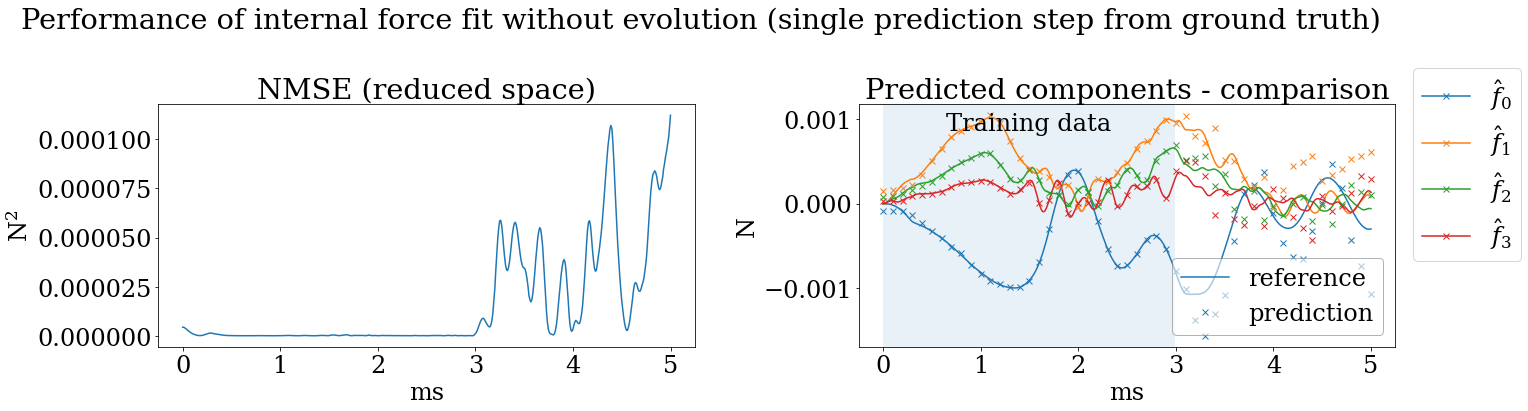

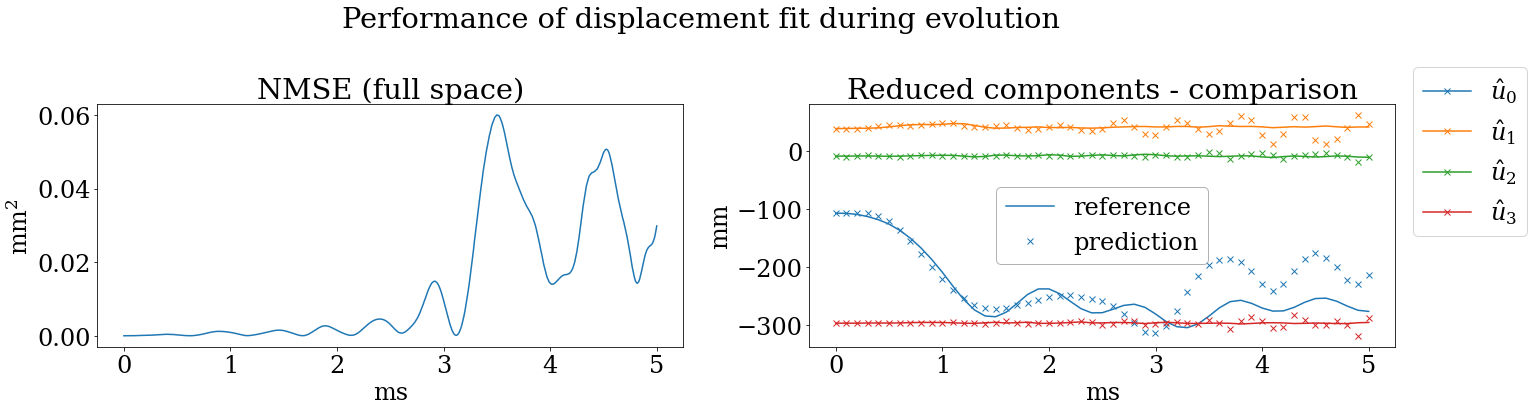

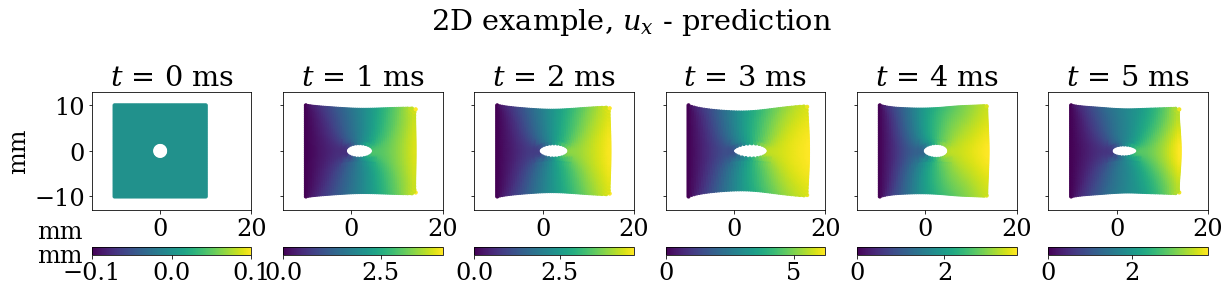

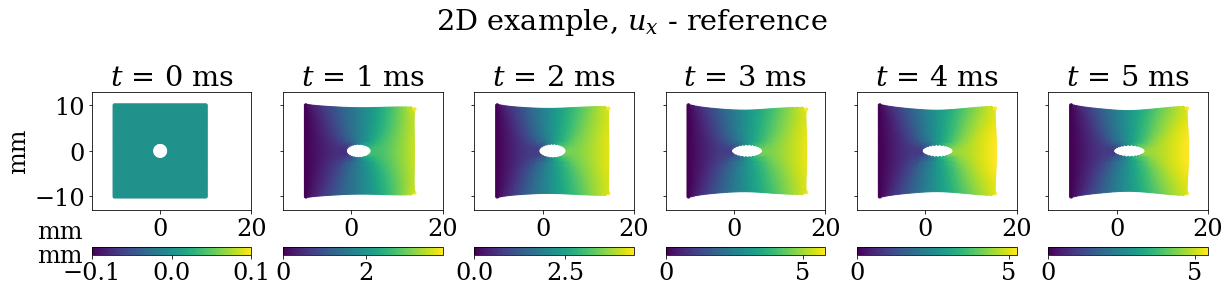

In [25]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=0.05)),dr_fint_delay23_dim9_trainfunc, dr_fint_delay23_dim9_trainfunc, dr_fint_delay23_dim9_ar_predfunc,4,training_stop=300)

'Saved to ../animations/plastic_takens9x23_4pods.gif'

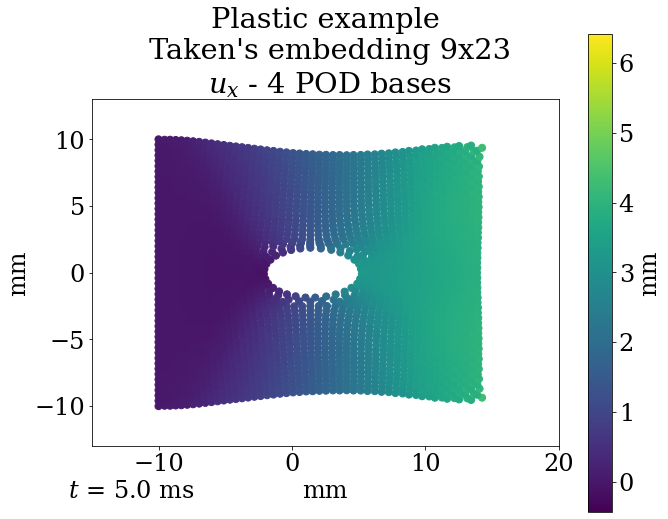

In [27]:
xroutinv = out['xroutinv']
dx_xroutinv = (xroutinv - xroutinv[0])[:,:xroutinv.shape[1]//2]
xx_xroutinv = mat2.xx[0] + xroutinv - xroutinv[0]
animatedplot2D(dx_xroutinv, xx_xroutinv[:,:xx_xroutinv.shape[1]//2],xx_xroutinv[:,xx_xroutinv.shape[1]//2:],
                path = "../animations/plastic_takens9x23_4pods",
                title = "Plastic example\n Taken's embedding 9x23\n $u_x$ - 4 POD bases",
               total_frames=100)

In [298]:
%%capture
alphas = np.arange(10)*0.1
maxs = []
sums = []
for a in alphas:
    out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=a)),dr_fint_delay23_dim9_trainfunc, dr_fint_delay23_dim9_trainfunc, dr_fint_delay23_dim9_ar_predfunc,4,training_stop=300)
    maxs.append(out["NMSE"].max())
    sums.append(out["NMSE"].sum())

#### Symmetric

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001D297C5CC70>(Reduced displacement + 8 offsets of reduced internal force with delay 6, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + 8 offsets of reduced internal force with delay 6
	POD components:	4
	Training range:	0:300/501
      0/Unknown - 6s 0s/sample - loss: 1.1366e-07Epoch 100/1000
800/800 [==============================] - 0s 77us/sample - loss: 1.2703e-08 - val_loss: 1.3523e-07


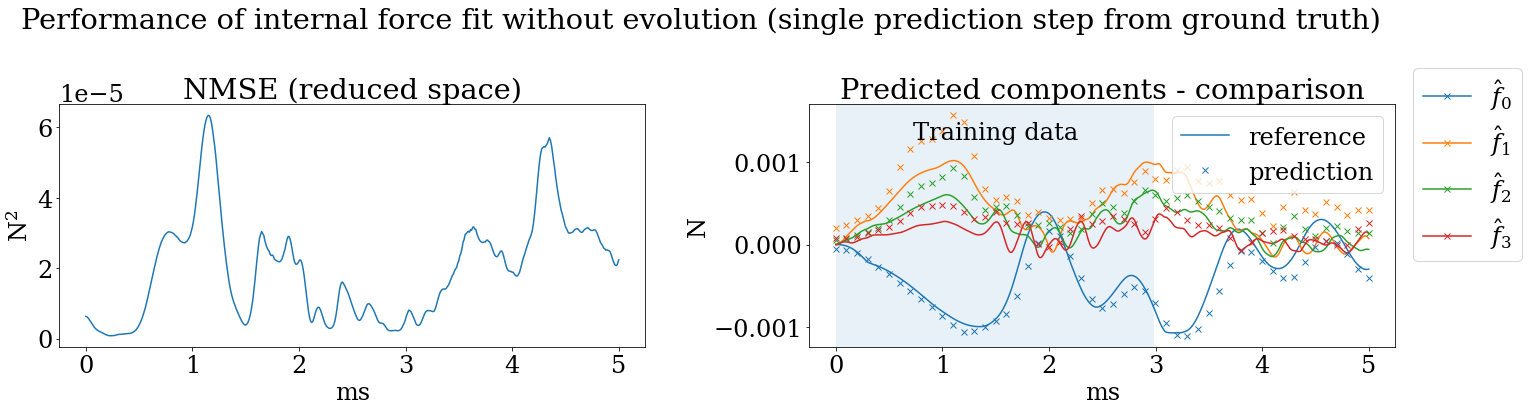

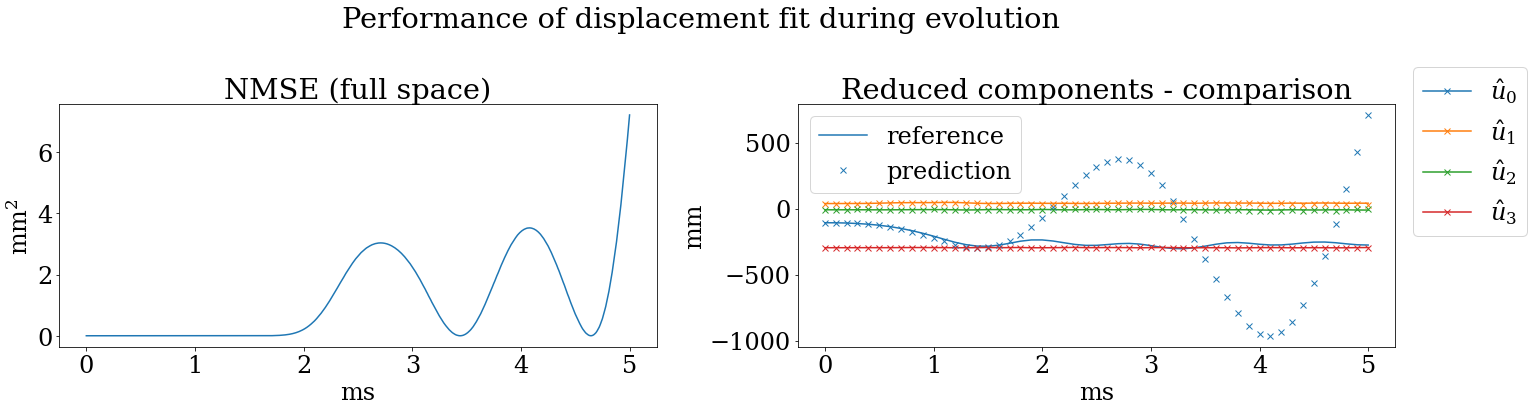

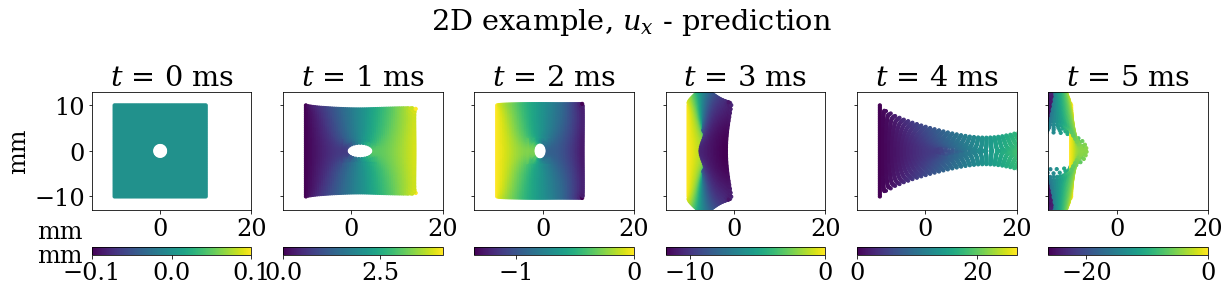

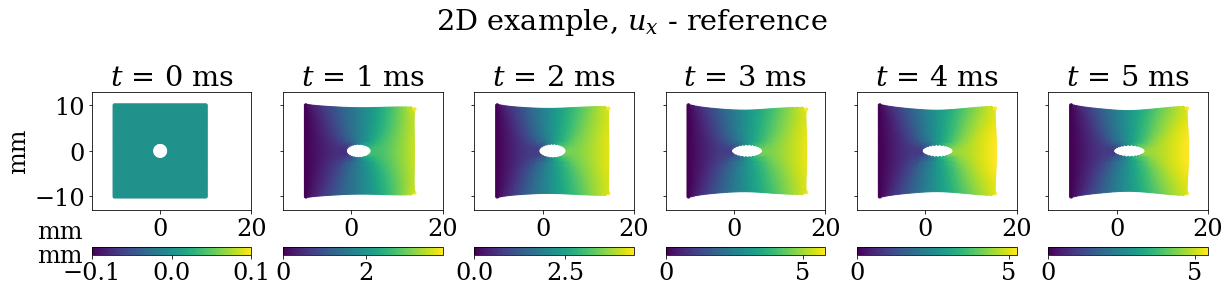

In [19]:
tf.random.set_seed(0)
best = SaveBest()
fit_params = dict(verbose=1, epochs=1000,batch_size=32,validation_split=0.25, callbacks=[EpochProgbar(skip_epochs=100),best])
out = evaluate2D(mat2,tfNSymmetricBuiltin_NormRegressor(4,n_squares=1,learning_rate=1.0),dr_fint_delay6_dim9_trainfunc, dr_fint_delay6_dim9_trainfunc, dr_fint_delay6_dim9_ar_predfunc,4,training_stop=300,fit_params=fit_params,save_best=best)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001D2B8320790>(Reduced displacement + 8 offsets of reduced internal force with delay 23, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement + 8 offsets of reduced internal force with delay 23
	POD components:	4
	Training range:	0:300/501
      0/Unknown - 2s 0s/sample - loss: 4.2979e-08Epoch 100/1000
1000/1000 [==============================] - 0s 28us/sample - loss: 3.8672e-08


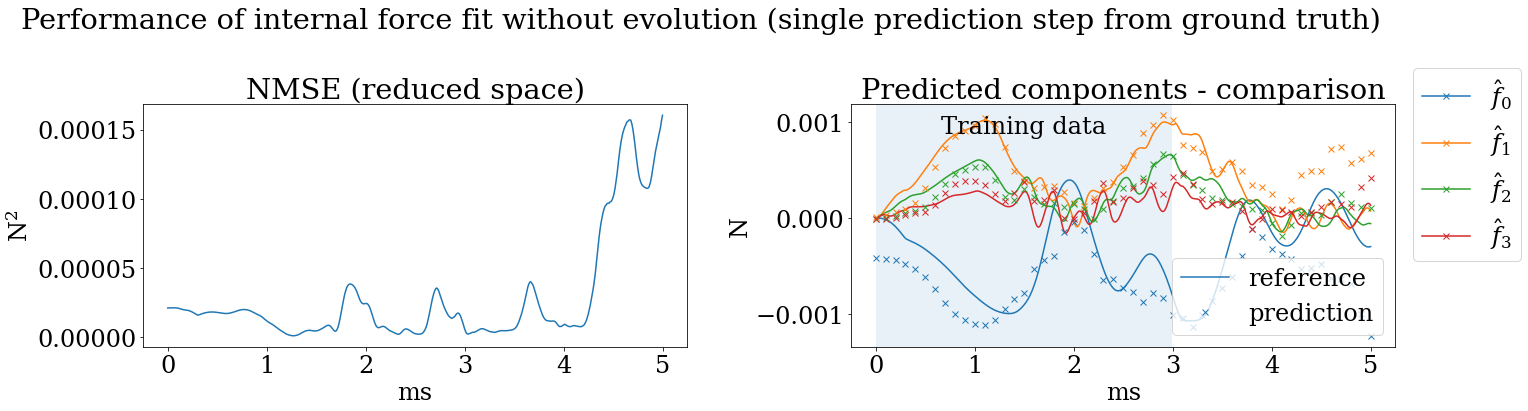

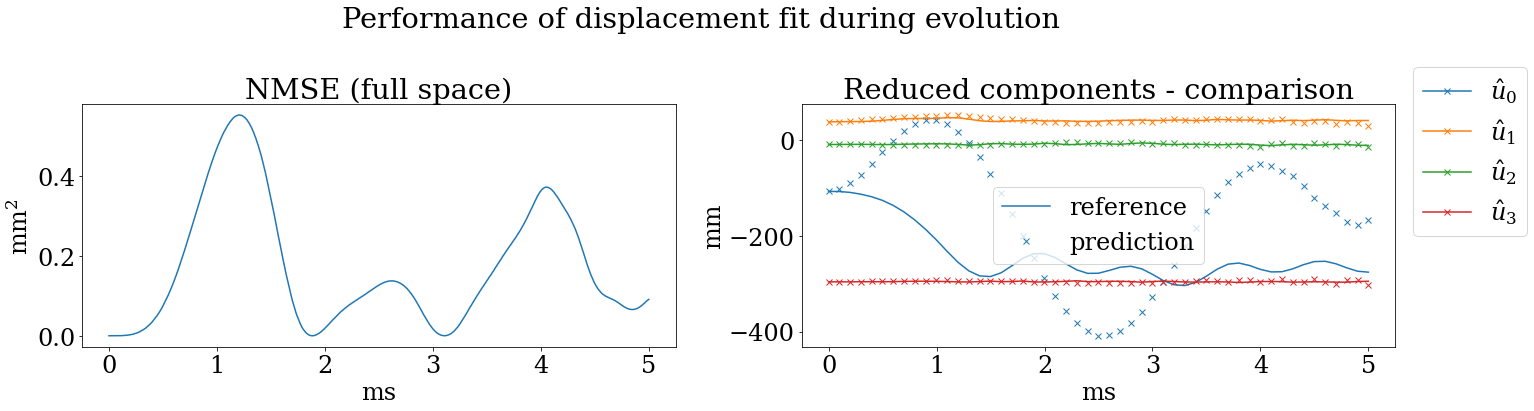

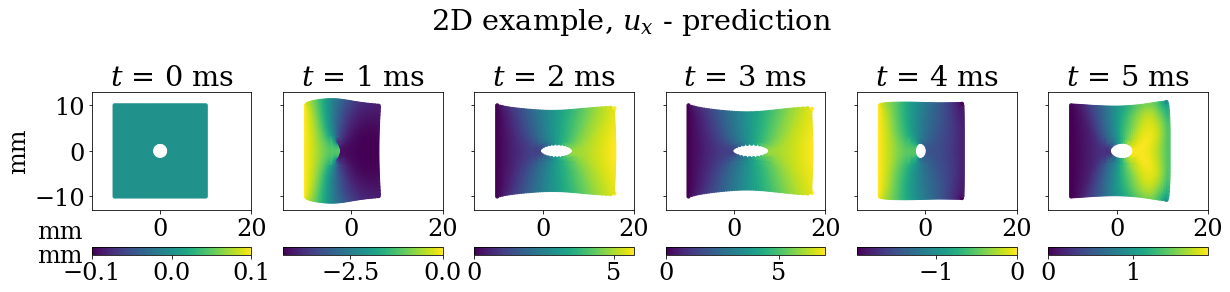

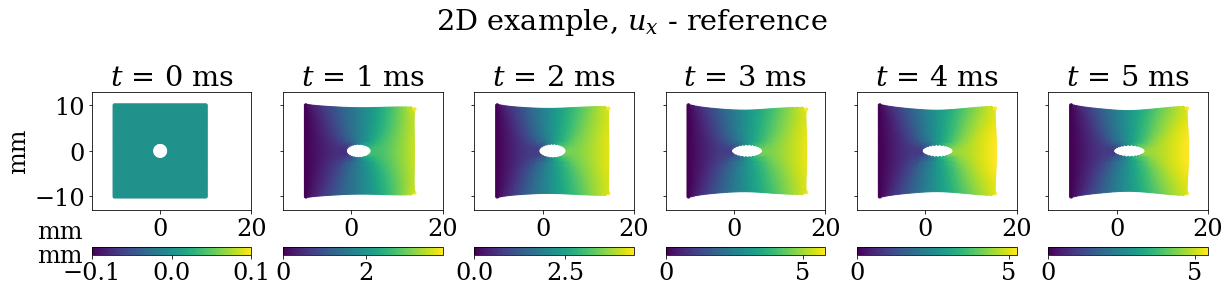

In [24]:
tf.random.set_seed(0)
best = SaveBest()
fit_params = dict(verbose=1, epochs=1000,batch_size=32, callbacks=[EpochProgbar(skip_epochs=100),])
out = evaluate2D(mat2,tfNSymmetricBuiltin_NormRegressor(4,n_squares=1,learning_rate=1.0),dr_fint_delay23_dim9_trainfunc, dr_fint_delay23_dim9_trainfunc, dr_fint_delay23_dim9_ar_predfunc,4,training_stop=300,fit_params=fit_params)

#### Polynomial

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('maxabsscaler', MaxAbsScaler()), ('ridge', Ridge(alpha=1000))])(Reduced displacement lifted with 3rd order monomial expansion + 8 offsets of reduced internal force with delay 6, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement lifted with 3rd order monomial expansion + 8 offsets of reduced internal force with delay 6
	POD components:	4
	Training range:	0:300/501


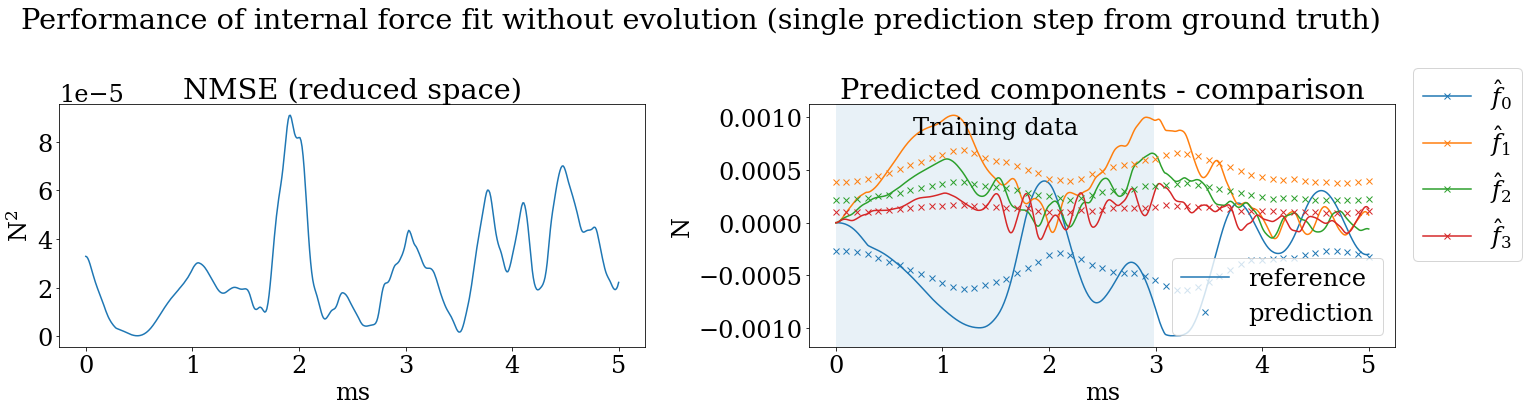

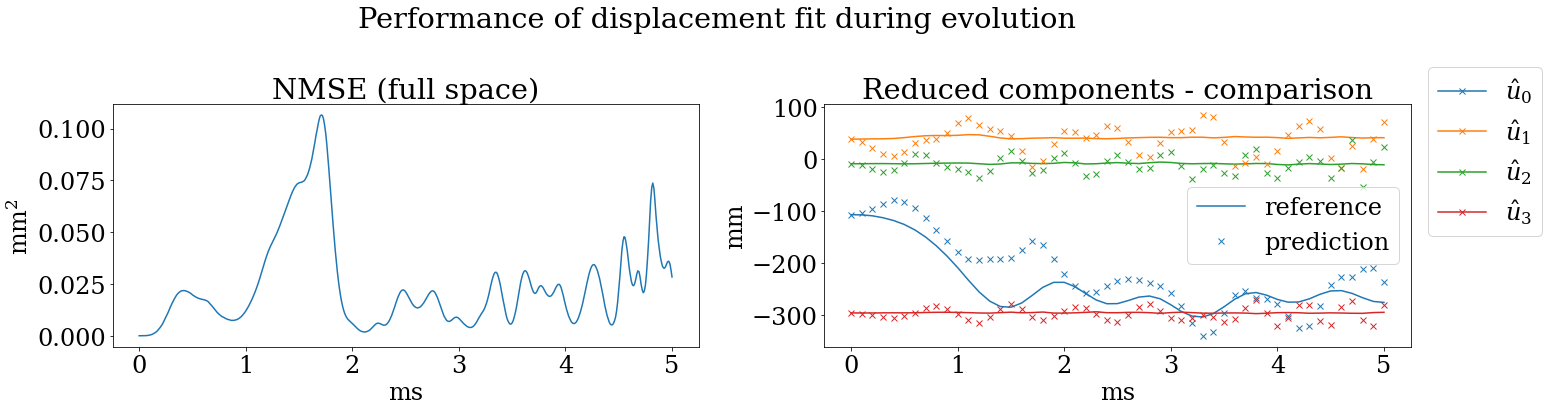

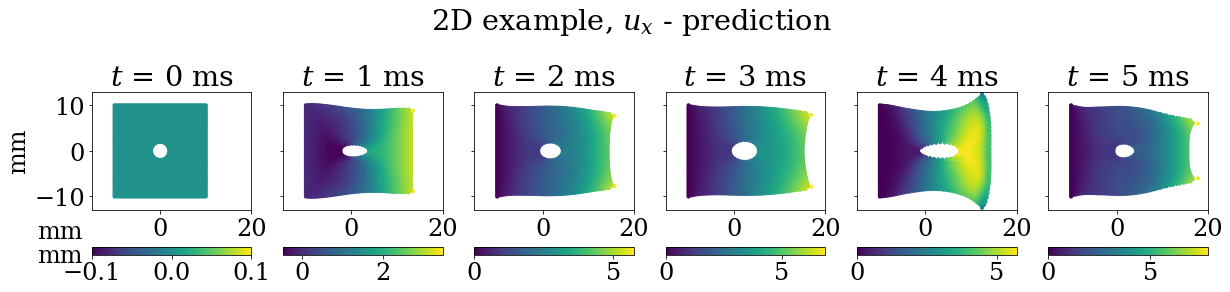

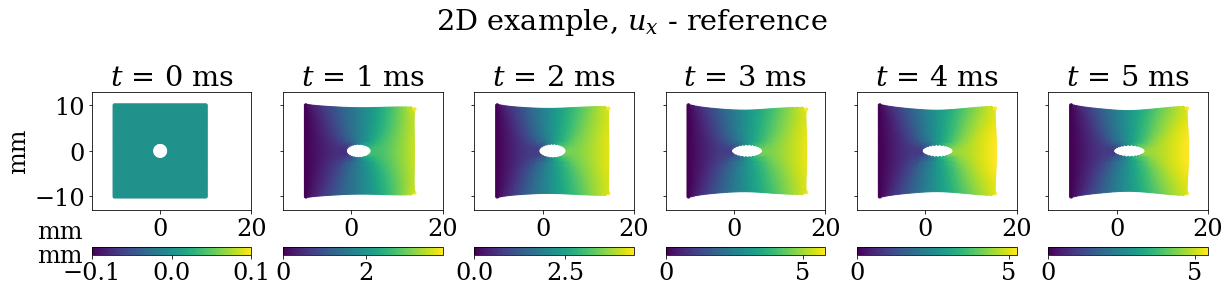

In [32]:
out = evaluate2D(mat2,make_pipeline(MaxAbsScaler(),Ridge(alpha=1000)),drlift_fint_delay6_dim9_trainfunc, drlift_fint_delay6_dim9_trainfunc, drlift_fint_delay6_dim9_ar_predfunc,4,training_stop=300)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001D2975B8F10>(Reduced displacement lifted with 3rd order monomial expansion + 3 offsets of reduced internal force with delay 6, Reduced Internal force)
	Acceleration function:	Prediction from reduced displacement lifted with 3rd order monomial expansion + 3 offsets of reduced internal force with delay 6
	POD components:	4
	Training range:	0:300/501
      0/Unknown - 3s 0s/sample - loss: 3.0279e-08Epoch 100/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 2.9860e-08
ValueError during prediction at i=127: 'Input contains NaN, infinity or a value too large for dtype('float64').'.
Predicting a=0 instead.
ValueError during prediction at i=128: 'Input contains NaN, infinity or a value too large for dtype('float64').'.
Predicting a=0 instead.
ValueError during prediction at i=129: 'Input contains NaN, infinity or a value too large for dtype(

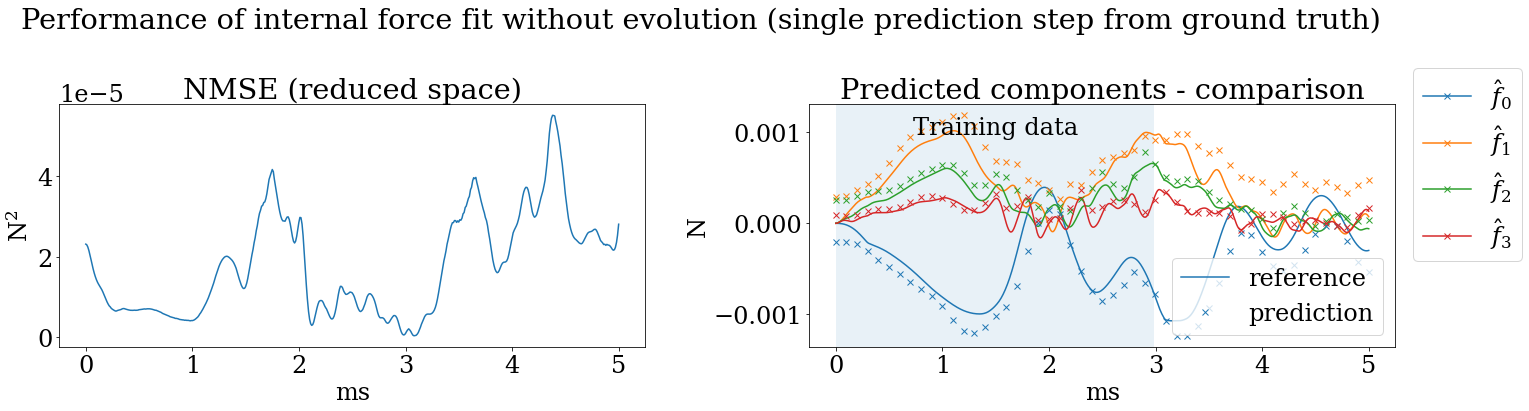

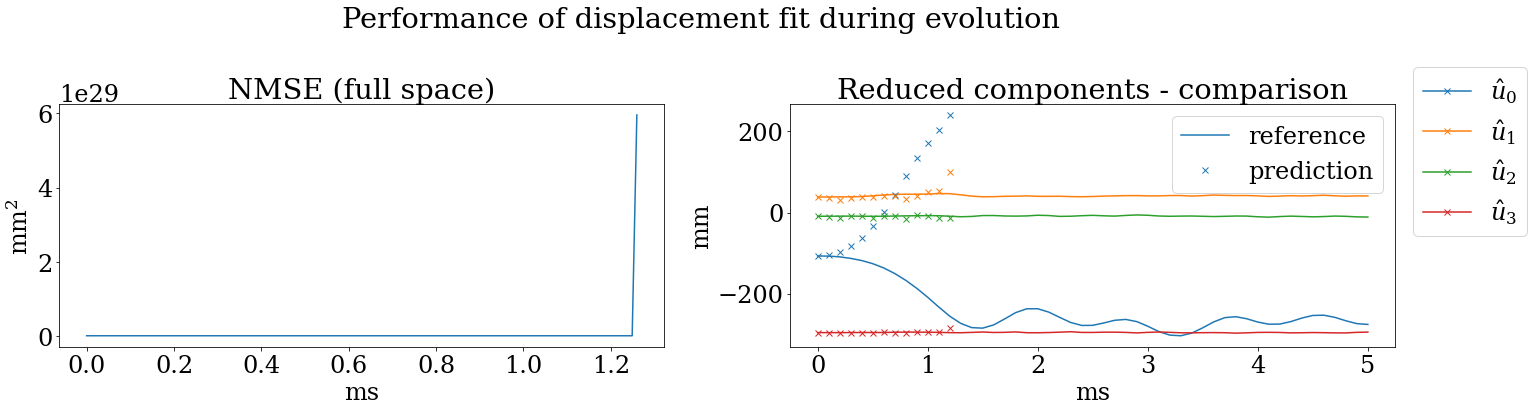

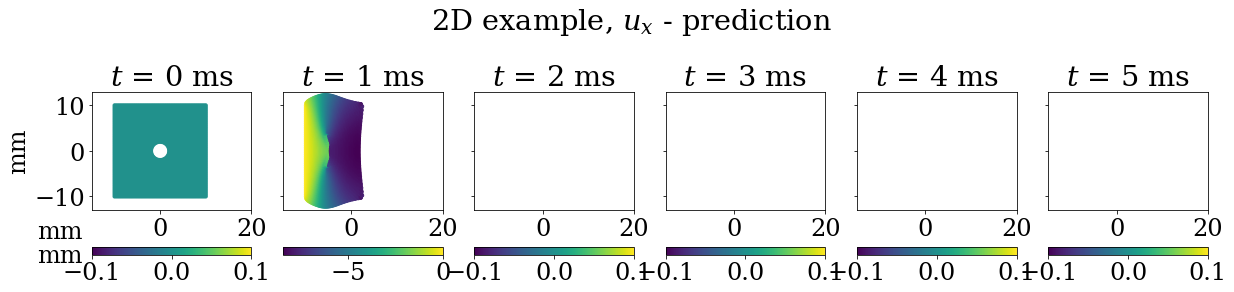

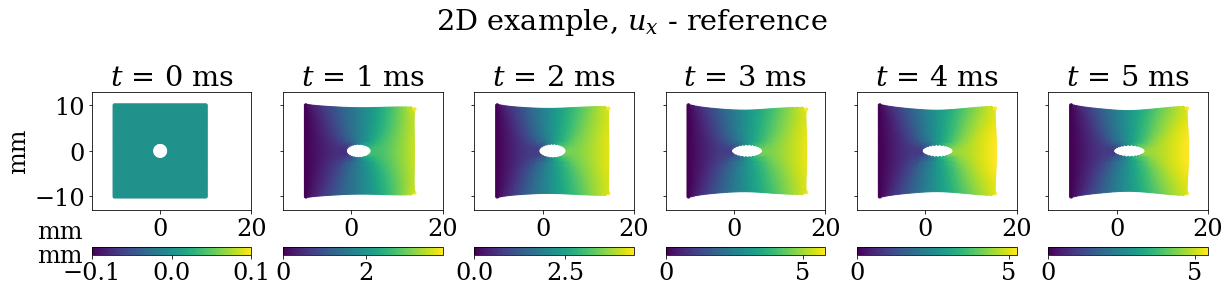

In [29]:
tf.random.set_seed(0)
best = SaveBest()
fit_params = dict(verbose=1, epochs=1000,batch_size=32, callbacks=[EpochProgbar(skip_epochs=100),])
out = evaluate2D(mat2,tfNSymmetricBuiltin_NormRegressor(4,n_squares=3,learning_rate=1.0),drlift_fint_delay6_dim4_trainfunc, drlift_fint_delay6_dim4_trainfunc, drlift_fint_delay6_dim4_ar_predfunc,4,training_stop=300,fit_params=fit_params)

## Effective plastic strain augmented models

### Helper functions

In [35]:
def dr_peps_trainfunc_base(mat, stop=501):

    x_train = np.hstack([
                mat.xr[:stop] - mat.xr[0],
                mat.peps_r[:stop]
            ])
    y_train = mat.fint_r[:stop]
    return x_train, y_train
    
dr_peps_trainfunc = NamedFunc(dr_peps_trainfunc_base,'Reduced displacement augmented with effective plastic strain')


def dr_peps_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    augment = mat.peps_r[i]
    augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], augment.reshape(1,-1)])
    try:
        fint_r_pred = model.predict(augmented_state.reshape(1,-1))
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\nPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_peps_ar_predfunc = NamedFunc(dr_peps_ar_predfunc_base, 'Prediction from displacement augmented with effective plastic strain')


### Evaluation

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	Pipeline(steps=[('ridge', Ridge(alpha=0))])(Reduced displacement augmented with effective plastic strain, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with effective plastic strain
	POD components:	4
	Training range:	0:300/501


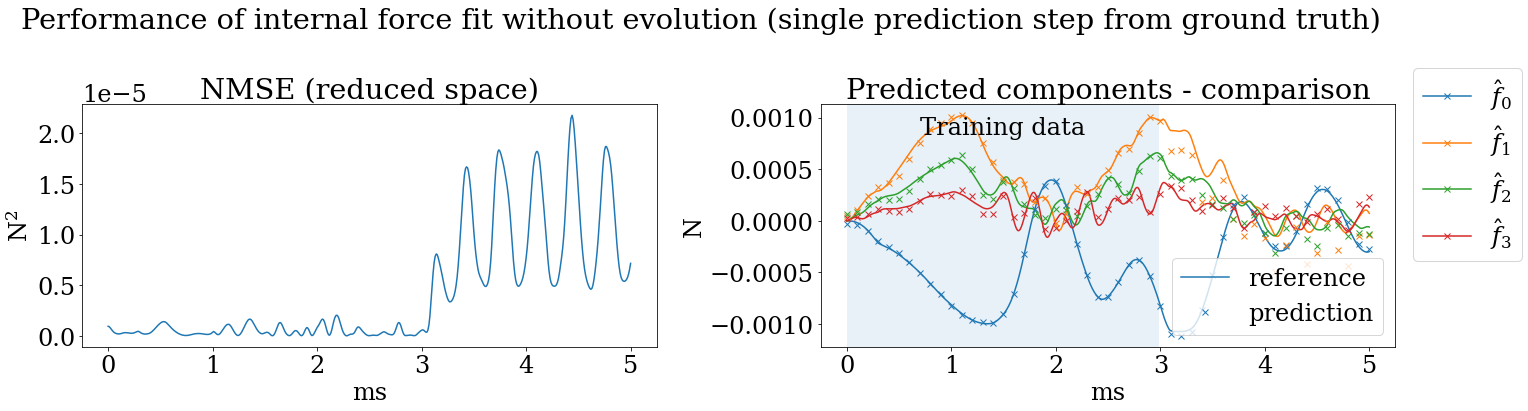

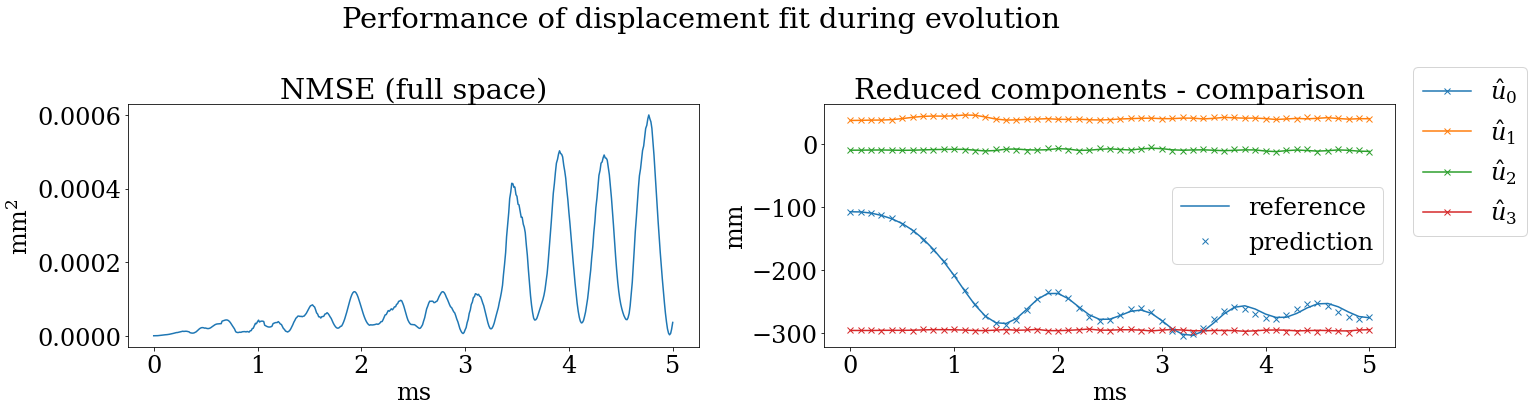

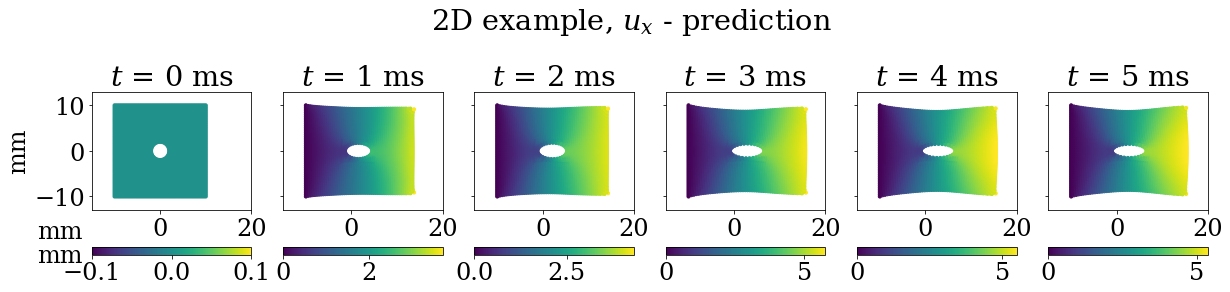

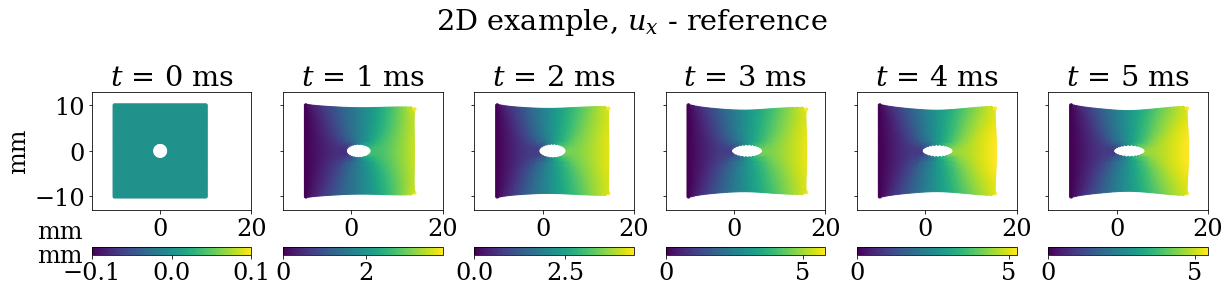

In [38]:
out = evaluate2D(mat2,make_pipeline(Ridge(alpha=0)),dr_peps_trainfunc, dr_peps_trainfunc, dr_peps_ar_predfunc,4,training_stop=300)